/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

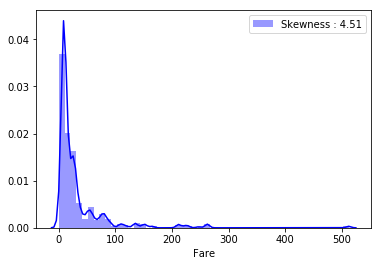

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('gender_submission.csv')

# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

df = pd.concat((train,test)).reset_index()
# Fill empty and NaNs values with NaN
df = df.fillna(np.nan)

# Get Title from Name
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
df["Title"].head()
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df["Title"] = df["Title"].astype(int)

# Create a family size descriptor from SibSp and Parch
df["Fsize"] = df["SibSp"] + df["Parch"] + 1

# Create new feature of family size
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

# Replace the Cabin number by the type of cabin 'X' if not
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])

## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
df["Ticket"] = Ticket
df["Ticket"].head()

#Fill Fare missing values with the median value
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
# Explore Fare distribution 
g = sns.distplot(df["Fare"], color="b", label="Skewness : %.2f"%(df["Fare"].skew()))
g = g.legend(loc="best")

# fill Age NA
index_NaN_age = list(df["Age"][df["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = df["Age"].median()
    age_pred = df["Age"][((df['SibSp'] == df.iloc[i]["SibSp"]) & (df['Parch'] == df.iloc[i]["Parch"]) & (df['Pclass'] == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df['Age'].iloc[i] = age_pred
    else :
        df['Age'].iloc[i] = age_med

#Fill Embarked nan values of dataset set with 'S' most frequent value
df["Embarked"] = df["Embarked"].fillna("S")

# Apply log to Fare to reduce skewness distribution
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
# convert Sex into categorical value 0 for male and 1 for female
df["Sex"] = df["Sex"].map({"male": 0, "female":1})

# Explore Fare distribution 
g = sns.distplot(df["Fare"], color="b", label="Skewness : %.2f"%(df["Fare"].skew()))
g = g.legend(loc="best")

# convert to indicator values Title and Embarked 
df = pd.get_dummies(df, columns = ["Title"])
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Em")
df = pd.get_dummies(df, columns = ["Cabin"],prefix="Cabin")

## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")

# Create categorical values for Pclass
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"],prefix="Pc")

tr = df[df.Survived.isna()==False]
te = df[df.Survived.isna()==True]
label = tr.Survived
tr = tr.drop(columns=['Name','Survived','index','PassengerId'])
te = te.drop(columns=['Name','Survived','index','PassengerId'])

from sklearn.model_selection import train_test_split
train_data, valid_data, train_target, valid_target = train_test_split(tr, label, test_size=0.1, random_state=9)

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


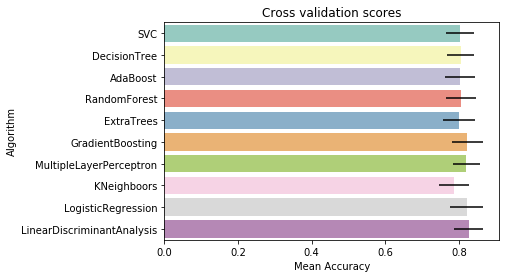

In [33]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, tr, y = label, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [19]:
#Hyperopt

from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, rand
from sklearn.linear_model import LogisticRegression   

parameter_space_logit ={
    # loguniform表示该参数取对数后符合均匀分布
    'C':hp.loguniform("C", np.log(1), np.log(100)),
    #'dual':hp.choice('dual',[1,0]),
    'penalty':hp.choice('penalty',['l1','l2']),
}

count = 0

def function(args):
    print(args)

    # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
    clf = LogisticRegression(**args)

    # 训练模型
    clf.fit(train_data,train_target)

    # 预测测试集
    prediction = clf.predict(valid_data)

    global count
    count = count + 1
    score = accuracy_score(valid_target, prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解
best = fmin(function, parameter_space_logit, algo=tpe.suggest, max_evals=1000)

# best["kernel"]返回的是数组下标，因此需要把它还原回来
penalty_list = ['l1','l2']
best["penalty"] = penalty_list[best["penalty"]]

print("最佳参数为：",best)

{'C': 1.1811596639700297, 'penalty': 'l1'}
第1次，测试集正确率为： 0.797752808988764
{'C': 1.187239787482011, 'penalty': 'l2'}
第2次，测试集正确率为： 0.797752808988764
{'C': 34.51785015652973, 'penalty': 'l1'}
第3次，测试集正确率为： 0.8089887640449438
{'C': 45.18832945409946, 'penalty': 'l1'}
第4次，测试集正确率为： 0.8089887640449438
{'C': 81.88085247716481, 'penalty': 'l2'}
第5次，测试集正确率为： 0.8089887640449438
{'C': 8.276929664637095, 'penalty': 'l2'}
第6次，测试集正确率为： 0.8089887640449438
{'C': 6.620791328636051, 'penalty': 'l2'}
第7次，测试集正确率为： 0.8089887640449438
{'C': 23.372765853922125, 'penalty': 'l1'}
第8次，测试集正确率为： 0.8089887640449438
{'C': 2.6387143338997094, 'penalty': 'l2'}
第9次，测试集正确率为： 0.797752808988764
{'C': 10.101564146361412, 'penalty': 'l2'}
第10次，测试集正确率为： 0.8089887640449438
{'C': 67.12199129961817, 'penalty': 'l2'}
第11次，测试集正确率为： 0.8089887640449438
{'C': 12.242715050581891, 'penalty': 'l1'}
第12次，测试集正确率为： 0.8089887640449438
{'C': 5.225151309652232, 'penalty': 'l2'}
第13次，测试集正确率为： 0.797752808988764
{'C': 21.408548114682194, 'penalt

第110次，测试集正确率为： 0.8089887640449438
{'C': 1.6674959207318452, 'penalty': 'l1'}
第111次，测试集正确率为： 0.797752808988764
{'C': 23.30272070780064, 'penalty': 'l2'}
第112次，测试集正确率为： 0.8089887640449438
{'C': 42.83503481042722, 'penalty': 'l2'}
第113次，测试集正确率为： 0.8089887640449438
{'C': 55.97569184106004, 'penalty': 'l2'}
第114次，测试集正确率为： 0.8089887640449438
{'C': 35.33897290226811, 'penalty': 'l1'}
第115次，测试集正确率为： 0.8089887640449438
{'C': 61.17458478546759, 'penalty': 'l2'}
第116次，测试集正确率为： 0.8089887640449438
{'C': 71.71067595035072, 'penalty': 'l2'}
第117次，测试集正确率为： 0.8089887640449438
{'C': 99.02257649209017, 'penalty': 'l1'}
第118次，测试集正确率为： 0.8089887640449438
{'C': 2.6016293365665124, 'penalty': 'l1'}
第119次，测试集正确率为： 0.8089887640449438
{'C': 3.805897373764814, 'penalty': 'l1'}
第120次，测试集正确率为： 0.8089887640449438
{'C': 3.032223201317155, 'penalty': 'l1'}
第121次，测试集正确率为： 0.8089887640449438
{'C': 2.012495397227489, 'penalty': 'l1'}
第122次，测试集正确率为： 0.8089887640449438
{'C': 2.1025794715526813, 'penalty': 'l1'}
第123次，测试集正

{'C': 10.22248083488384, 'penalty': 'l2'}
第225次，测试集正确率为： 0.8089887640449438
{'C': 45.18784199285023, 'penalty': 'l2'}
第226次，测试集正确率为： 0.8089887640449438
{'C': 32.65824595785568, 'penalty': 'l2'}
第227次，测试集正确率为： 0.8089887640449438
{'C': 57.53652854479641, 'penalty': 'l2'}
第228次，测试集正确率为： 0.8089887640449438
{'C': 5.184983323085416, 'penalty': 'l2'}
第229次，测试集正确率为： 0.797752808988764
{'C': 76.3263246362788, 'penalty': 'l2'}
第230次，测试集正确率为： 0.8089887640449438
{'C': 8.30446728819541, 'penalty': 'l2'}
第231次，测试集正确率为： 0.8089887640449438
{'C': 5.929942339063878, 'penalty': 'l2'}
第232次，测试集正确率为： 0.797752808988764
{'C': 82.13973368029009, 'penalty': 'l1'}
第233次，测试集正确率为： 0.8089887640449438
{'C': 8.28568082128168, 'penalty': 'l2'}
第234次，测试集正确率为： 0.8089887640449438
{'C': 4.855701599162148, 'penalty': 'l2'}
第235次，测试集正确率为： 0.797752808988764
{'C': 46.60626003408859, 'penalty': 'l1'}
第236次，测试集正确率为： 0.8089887640449438
{'C': 11.441159097845343, 'penalty': 'l1'}
第237次，测试集正确率为： 0.8089887640449438
{'C': 5.463003450

{'C': 5.993393789527855, 'penalty': 'l2'}
第340次，测试集正确率为： 0.797752808988764
{'C': 10.998337195383105, 'penalty': 'l2'}
第341次，测试集正确率为： 0.8089887640449438
{'C': 4.967063999277484, 'penalty': 'l2'}
第342次，测试集正确率为： 0.797752808988764
{'C': 12.291567038152715, 'penalty': 'l2'}
第343次，测试集正确率为： 0.8089887640449438
{'C': 4.4095030221802345, 'penalty': 'l2'}
第344次，测试集正确率为： 0.797752808988764
{'C': 18.509172960376215, 'penalty': 'l2'}
第345次，测试集正确率为： 0.8089887640449438
{'C': 10.678022899609296, 'penalty': 'l2'}
第346次，测试集正确率为： 0.8089887640449438
{'C': 9.04907998764909, 'penalty': 'l2'}
第347次，测试集正确率为： 0.8089887640449438
{'C': 33.060424936385864, 'penalty': 'l2'}
第348次，测试集正确率为： 0.8089887640449438
{'C': 46.004982411596366, 'penalty': 'l2'}
第349次，测试集正确率为： 0.8089887640449438
{'C': 70.38606660263545, 'penalty': 'l2'}
第350次，测试集正确率为： 0.8089887640449438
{'C': 78.7303683172642, 'penalty': 'l2'}
第351次，测试集正确率为： 0.8089887640449438
{'C': 82.7975850568979, 'penalty': 'l1'}
第352次，测试集正确率为： 0.8089887640449438
{'C': 93.14

{'C': 60.00869041533591, 'penalty': 'l2'}
第454次，测试集正确率为： 0.8089887640449438
{'C': 96.7311008468514, 'penalty': 'l2'}
第455次，测试集正确率为： 0.8089887640449438
{'C': 1.6215551367439769, 'penalty': 'l1'}
第456次，测试集正确率为： 0.797752808988764
{'C': 6.471366690129578, 'penalty': 'l1'}
第457次，测试集正确率为： 0.8089887640449438
{'C': 5.867452615720242, 'penalty': 'l1'}
第458次，测试集正确率为： 0.8089887640449438
{'C': 9.554221861436428, 'penalty': 'l1'}
第459次，测试集正确率为： 0.8089887640449438
{'C': 17.905446553980937, 'penalty': 'l2'}
第460次，测试集正确率为： 0.8089887640449438
{'C': 16.406426133711935, 'penalty': 'l2'}
第461次，测试集正确率为： 0.8089887640449438
{'C': 15.751565543944574, 'penalty': 'l2'}
第462次，测试集正确率为： 0.8089887640449438
{'C': 16.85416856614907, 'penalty': 'l2'}
第463次，测试集正确率为： 0.8089887640449438
{'C': 21.717081197384363, 'penalty': 'l2'}
第464次，测试集正确率为： 0.8089887640449438
{'C': 24.623645770794415, 'penalty': 'l2'}
第465次，测试集正确率为： 0.8089887640449438
{'C': 14.491118398566758, 'penalty': 'l2'}
第466次，测试集正确率为： 0.8089887640449438
{'C': 1

第561次，测试集正确率为： 0.8089887640449438
{'C': 13.031941800808488, 'penalty': 'l2'}
第562次，测试集正确率为： 0.8089887640449438
{'C': 9.023963080505524, 'penalty': 'l2'}
第563次，测试集正确率为： 0.8089887640449438
{'C': 7.469211088048382, 'penalty': 'l2'}
第564次，测试集正确率为： 0.8089887640449438
{'C': 14.929291128826247, 'penalty': 'l1'}
第565次，测试集正确率为： 0.8089887640449438
{'C': 12.17007056333158, 'penalty': 'l1'}
第566次，测试集正确率为： 0.8089887640449438
{'C': 17.9654153714045, 'penalty': 'l1'}
第567次，测试集正确率为： 0.8089887640449438
{'C': 33.00223432179463, 'penalty': 'l2'}
第568次，测试集正确率为： 0.8089887640449438
{'C': 59.62974688846991, 'penalty': 'l2'}
第569次，测试集正确率为： 0.8089887640449438
{'C': 15.57738380508157, 'penalty': 'l1'}
第570次，测试集正确率为： 0.8089887640449438
{'C': 7.146914079251812, 'penalty': 'l1'}
第571次，测试集正确率为： 0.8089887640449438
{'C': 99.86429138632523, 'penalty': 'l1'}
第572次，测试集正确率为： 0.8089887640449438
{'C': 91.70269424239149, 'penalty': 'l1'}
第573次，测试集正确率为： 0.8089887640449438
{'C': 8.214449538663688, 'penalty': 'l1'}
第574次，测试集正确

{'C': 3.241787541469477, 'penalty': 'l1'}
第673次，测试集正确率为： 0.8089887640449438
{'C': 4.056030254708609, 'penalty': 'l1'}
第674次，测试集正确率为： 0.8089887640449438
{'C': 2.242139490321305, 'penalty': 'l1'}
第675次，测试集正确率为： 0.8089887640449438
{'C': 3.349411836321554, 'penalty': 'l1'}
第676次，测试集正确率为： 0.8089887640449438
{'C': 2.7674810596529893, 'penalty': 'l1'}
第677次，测试集正确率为： 0.8089887640449438
{'C': 3.8428076481406053, 'penalty': 'l1'}
第678次，测试集正确率为： 0.8089887640449438
{'C': 2.0930374823016864, 'penalty': 'l1'}
第679次，测试集正确率为： 0.8089887640449438
{'C': 2.4000617639142225, 'penalty': 'l1'}
第680次，测试集正确率为： 0.8089887640449438
{'C': 3.1685673416359825, 'penalty': 'l1'}
第681次，测试集正确率为： 0.8089887640449438
{'C': 1.0729163246062825, 'penalty': 'l2'}
第682次，测试集正确率为： 0.797752808988764
{'C': 3.6704329781737943, 'penalty': 'l1'}
第683次，测试集正确率为： 0.8089887640449438
{'C': 5.310873088713178, 'penalty': 'l1'}
第684次，测试集正确率为： 0.8089887640449438
{'C': 4.769617072629683, 'penalty': 'l1'}
第685次，测试集正确率为： 0.8089887640449438
{'C': 

{'C': 8.4533794659887, 'penalty': 'l1'}
第785次，测试集正确率为： 0.8089887640449438
{'C': 11.702742885718463, 'penalty': 'l1'}
第786次，测试集正确率为： 0.8089887640449438
{'C': 9.412353699369753, 'penalty': 'l2'}
第787次，测试集正确率为： 0.8089887640449438
{'C': 10.637419803628747, 'penalty': 'l2'}
第788次，测试集正确率为： 0.8089887640449438
{'C': 10.750720264229182, 'penalty': 'l2'}
第789次，测试集正确率为： 0.8089887640449438
{'C': 12.161016429390145, 'penalty': 'l2'}
第790次，测试集正确率为： 0.8089887640449438
{'C': 11.869103759043183, 'penalty': 'l2'}
第791次，测试集正确率为： 0.8089887640449438
{'C': 10.460176783722565, 'penalty': 'l2'}
第792次，测试集正确率为： 0.8089887640449438
{'C': 11.30728207538419, 'penalty': 'l2'}
第793次，测试集正确率为： 0.8089887640449438
{'C': 14.245282450626434, 'penalty': 'l2'}
第794次，测试集正确率为： 0.8089887640449438
{'C': 18.83215047324567, 'penalty': 'l2'}
第795次，测试集正确率为： 0.8089887640449438
{'C': 9.841692439852936, 'penalty': 'l2'}
第796次，测试集正确率为： 0.8089887640449438
{'C': 39.06430298144662, 'penalty': 'l2'}
第797次，测试集正确率为： 0.8089887640449438
{'C': 5

{'C': 87.89113664623048, 'penalty': 'l2'}
第900次，测试集正确率为： 0.8089887640449438
{'C': 99.93928698360352, 'penalty': 'l2'}
第901次，测试集正确率为： 0.8089887640449438
{'C': 22.921987882849653, 'penalty': 'l2'}
第902次，测试集正确率为： 0.8089887640449438
{'C': 23.330406468805624, 'penalty': 'l2'}
第903次，测试集正确率为： 0.8089887640449438
{'C': 78.14831287867943, 'penalty': 'l2'}
第904次，测试集正确率为： 0.8089887640449438
{'C': 92.07236599423415, 'penalty': 'l1'}
第905次，测试集正确率为： 0.8089887640449438
{'C': 99.54187758250683, 'penalty': 'l2'}
第906次，测试集正确率为： 0.8089887640449438
{'C': 99.19312383651344, 'penalty': 'l2'}
第907次，测试集正确率为： 0.8089887640449438
{'C': 74.6408330783631, 'penalty': 'l2'}
第908次，测试集正确率为： 0.8089887640449438
{'C': 59.78579955659834, 'penalty': 'l2'}
第909次，测试集正确率为： 0.8089887640449438
{'C': 99.69112342774598, 'penalty': 'l2'}
第910次，测试集正确率为： 0.8089887640449438
{'C': 68.51698307689855, 'penalty': 'l2'}
第911次，测试集正确率为： 0.8089887640449438
{'C': 10.301044013190866, 'penalty': 'l2'}
第912次，测试集正确率为： 0.8089887640449438
{'C': 9.97

In [21]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, rand
from sklearn.ensemble import RandomForestClassifier

parameter_space_forest ={
    # loguniform表示该参数取对数后符合均匀分布
    'max_depth':hp.randint("max_depth", 39)+1,
    'criterion':hp.choice('criterion',['gini','entropy']),
    'bootstrap':hp.choice('bootstrap',[1,0]),
    'n_estimators':hp.randint('n_estimators', 60)+1,
    'max_features':hp.uniform('max_features', 0.2, 0.8),
    'min_samples_leaf':hp.randint('min_samples_leaf',80)+1,
    'random_state':40
}

count = 0

def function(args):
    print(args)

    # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
    clf = RandomForestClassifier(**args)

    # 训练模型
    clf.fit(train_data,train_target)

    # 预测测试集
    prediction = clf.predict(valid_data)

    global count
    count = count + 1
    score = accuracy_score(valid_target, prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解
best = fmin(function, parameter_space_forest, algo=tpe.suggest, max_evals=1000)

# best["kernel"]返回的是数组下标，因此需要把它还原回来
bootstrap_list = [1,0]
best["bootstrap"] = bootstrap_list[best["bootstrap"]]

criterion_list = ['gini','entropy']
best["criterion"] = criterion_list[best["criterion"]]

print("最佳参数为：",best)

{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.4801423862953969, 'min_samples_leaf': 40, 'n_estimators': 1, 'random_state': 40}
第1次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 26, 'max_features': 0.31227413911199886, 'min_samples_leaf': 70, 'n_estimators': 11, 'random_state': 40}
第2次，测试集正确率为： 0.7528089887640449
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.704569933080168, 'min_samples_leaf': 38, 'n_estimators': 56, 'random_state': 40}
第3次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 28, 'max_features': 0.260427809640166, 'min_samples_leaf': 15, 'n_estimators': 41, 'random_state': 40}
第4次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 0.30495900597931097, 'min_samples_leaf': 57, 'n_estimators': 4, 'random_state': 40}
第5次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 29, 'max

第44次，测试集正确率为： 0.7865168539325843
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.4947108579274942, 'min_samples_leaf': 16, 'n_estimators': 36, 'random_state': 40}
第45次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 27, 'max_features': 0.21695559242870244, 'min_samples_leaf': 8, 'n_estimators': 28, 'random_state': 40}
第46次，测试集正确率为： 0.8202247191011236
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 27, 'max_features': 0.23554483396757608, 'min_samples_leaf': 8, 'n_estimators': 58, 'random_state': 40}
第47次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.26901409043041485, 'min_samples_leaf': 76, 'n_estimators': 28, 'random_state': 40}
第48次，测试集正确率为： 0.7191011235955056
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.2927696544386791, 'min_samples_leaf': 7, 'n_estimators': 60, 'random_state': 40}
第49次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criter

{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 38, 'max_features': 0.5397791218837585, 'min_samples_leaf': 2, 'n_estimators': 8, 'random_state': 40}
第89次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.42978384386203955, 'min_samples_leaf': 28, 'n_estimators': 56, 'random_state': 40}
第90次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 39, 'max_features': 0.5735781931174022, 'min_samples_leaf': 48, 'n_estimators': 21, 'random_state': 40}
第91次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 0.2157858189106039, 'min_samples_leaf': 5, 'n_estimators': 25, 'random_state': 40}
第92次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 11, 'max_features': 0.7106707284731305, 'min_samples_leaf': 33, 'n_estimators': 28, 'random_state': 40}
第93次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 6, 'max_fe

第134次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 9, 'max_features': 0.4618985761942863, 'min_samples_leaf': 30, 'n_estimators': 15, 'random_state': 40}
第135次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 12, 'max_features': 0.6938677146740794, 'min_samples_leaf': 27, 'n_estimators': 53, 'random_state': 40}
第136次，测试集正确率为： 0.797752808988764
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 34, 'max_features': 0.34931164506424506, 'min_samples_leaf': 18, 'n_estimators': 27, 'random_state': 40}
第137次，测试集正确率为： 0.797752808988764
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 0.5378154749758526, 'min_samples_leaf': 71, 'n_estimators': 24, 'random_state': 40}
第138次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 14, 'max_features': 0.5630947575726749, 'min_samples_leaf': 60, 'n_estimators': 33, 'random_state': 40}
第139次，测试集正确率为： 0.7303370786516854
{'bootstrap': 0, 'cr

{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 12, 'max_features': 0.2781914110664458, 'min_samples_leaf': 21, 'n_estimators': 13, 'random_state': 40}
第179次，测试集正确率为： 0.797752808988764
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 18, 'max_features': 0.4606797565671382, 'min_samples_leaf': 48, 'n_estimators': 51, 'random_state': 40}
第180次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 38, 'max_features': 0.6567575861183099, 'min_samples_leaf': 5, 'n_estimators': 58, 'random_state': 40}
第181次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 0.7552164396532104, 'min_samples_leaf': 33, 'n_estimators': 43, 'random_state': 40}
第182次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 9, 'max_features': 0.7049618045414533, 'min_samples_leaf': 11, 'n_estimators': 14, 'random_state': 40}
第183次，测试集正确率为： 0.8202247191011236
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 35, 

第223次，测试集正确率为： 0.8314606741573034
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.7175956443017671, 'min_samples_leaf': 18, 'n_estimators': 9, 'random_state': 40}
第224次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 27, 'max_features': 0.5801252044846187, 'min_samples_leaf': 7, 'n_estimators': 9, 'random_state': 40}
第225次，测试集正确率为： 0.8202247191011236
{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 27, 'max_features': 0.6988714822032394, 'min_samples_leaf': 18, 'n_estimators': 9, 'random_state': 40}
第226次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 39, 'max_features': 0.5039032911146779, 'min_samples_leaf': 47, 'n_estimators': 56, 'random_state': 40}
第227次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 0.656118605468158, 'min_samples_leaf': 62, 'n_estimators': 17, 'random_state': 40}
第228次，测试集正确率为： 0.7752808988764045
{'bootstrap'

第268次，测试集正确率为： 0.8089887640449438
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 11, 'max_features': 0.41189048711805276, 'min_samples_leaf': 22, 'n_estimators': 9, 'random_state': 40}
第269次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 28, 'max_features': 0.6377072835876045, 'min_samples_leaf': 21, 'n_estimators': 30, 'random_state': 40}
第270次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.20241428842345846, 'min_samples_leaf': 11, 'n_estimators': 42, 'random_state': 40}
第271次，测试集正确率为： 0.8202247191011236
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.26182940472571814, 'min_samples_leaf': 10, 'n_estimators': 42, 'random_state': 40}
第272次，测试集正确率为： 0.797752808988764
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 32, 'max_features': 0.4654087465542003, 'min_samples_leaf': 39, 'n_estimators': 22, 'random_state': 40}
第273次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'crit

第312次，测试集正确率为： 0.7528089887640449
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 37, 'max_features': 0.7917654472229659, 'min_samples_leaf': 78, 'n_estimators': 28, 'random_state': 40}
第313次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 1, 'max_features': 0.3632856105477508, 'min_samples_leaf': 4, 'n_estimators': 28, 'random_state': 40}
第314次，测试集正确率为： 0.7528089887640449
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 3, 'max_features': 0.3889095158233285, 'min_samples_leaf': 9, 'n_estimators': 17, 'random_state': 40}
第315次，测试集正确率为： 0.8089887640449438
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 33, 'max_features': 0.7039085978541202, 'min_samples_leaf': 54, 'n_estimators': 1, 'random_state': 40}
第316次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 15, 'max_features': 0.7326521194857173, 'min_samples_leaf': 25, 'n_estimators': 11, 'random_state': 40}
第317次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterio

第357次，测试集正确率为： 0.7528089887640449
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 16, 'max_features': 0.45444901236972607, 'min_samples_leaf': 74, 'n_estimators': 2, 'random_state': 40}
第358次，测试集正确率为： 0.7303370786516854
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 22, 'max_features': 0.2287673462684143, 'min_samples_leaf': 39, 'n_estimators': 7, 'random_state': 40}
第359次，测试集正确率为： 0.797752808988764
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 27, 'max_features': 0.5996951264307829, 'min_samples_leaf': 52, 'n_estimators': 37, 'random_state': 40}
第360次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.7454978702531672, 'min_samples_leaf': 15, 'n_estimators': 53, 'random_state': 40}
第361次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 34, 'max_features': 0.44335311556900103, 'min_samples_leaf': 67, 'n_estimators': 48, 'random_state': 40}
第362次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'crite

第401次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 9, 'max_features': 0.43325773666284234, 'min_samples_leaf': 66, 'n_estimators': 43, 'random_state': 40}
第402次，测试集正确率为： 0.7415730337078652
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 23, 'max_features': 0.6009345603366085, 'min_samples_leaf': 25, 'n_estimators': 45, 'random_state': 40}
第403次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 14, 'max_features': 0.48485831285372977, 'min_samples_leaf': 15, 'n_estimators': 51, 'random_state': 40}
第404次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.771004190094283, 'min_samples_leaf': 9, 'n_estimators': 10, 'random_state': 40}
第405次，测试集正确率为： 0.8202247191011236
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.33824363730851376, 'min_samples_leaf': 46, 'n_estimators': 42, 'random_state': 40}
第406次，测试集正确率为： 0.7865168539325843
{'bootstrap': 0, 'cr

第447次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 2, 'max_features': 0.757069620811831, 'min_samples_leaf': 74, 'n_estimators': 7, 'random_state': 40}
第448次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 27, 'max_features': 0.702465098838879, 'min_samples_leaf': 49, 'n_estimators': 27, 'random_state': 40}
第449次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 39, 'max_features': 0.7910819246250077, 'min_samples_leaf': 32, 'n_estimators': 3, 'random_state': 40}
第450次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 13, 'max_features': 0.7999707684725095, 'min_samples_leaf': 72, 'n_estimators': 54, 'random_state': 40}
第451次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 26, 'max_features': 0.7460389062068904, 'min_samples_leaf': 68, 'n_estimators': 6, 'random_state': 40}
第452次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criter

第491次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 32, 'max_features': 0.6921777112022154, 'min_samples_leaf': 66, 'n_estimators': 19, 'random_state': 40}
第492次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 4, 'max_features': 0.7389008835401513, 'min_samples_leaf': 70, 'n_estimators': 12, 'random_state': 40}
第493次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 25, 'max_features': 0.7224337558457341, 'min_samples_leaf': 53, 'n_estimators': 49, 'random_state': 40}
第494次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 38, 'max_features': 0.6500720505175576, 'min_samples_leaf': 9, 'n_estimators': 60, 'random_state': 40}
第495次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 2, 'max_features': 0.7990577445737823, 'min_samples_leaf': 51, 'n_estimators': 18, 'random_state': 40}
第496次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criteri

第536次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 9, 'max_features': 0.6194105694032582, 'min_samples_leaf': 67, 'n_estimators': 56, 'random_state': 40}
第537次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 28, 'max_features': 0.7569314163808537, 'min_samples_leaf': 22, 'n_estimators': 5, 'random_state': 40}
第538次，测试集正确率为： 0.7865168539325843
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 13, 'max_features': 0.7412226087686697, 'min_samples_leaf': 9, 'n_estimators': 50, 'random_state': 40}
第539次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.6743803702351033, 'min_samples_leaf': 68, 'n_estimators': 8, 'random_state': 40}
第540次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 39, 'max_features': 0.6425963938902658, 'min_samples_leaf': 40, 'n_estimators': 16, 'random_state': 40}
第541次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterio

第581次，测试集正确率为： 0.8314606741573034
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 18, 'max_features': 0.7158788462288328, 'min_samples_leaf': 58, 'n_estimators': 26, 'random_state': 40}
第582次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 17, 'max_features': 0.6489029142173797, 'min_samples_leaf': 4, 'n_estimators': 22, 'random_state': 40}
第583次，测试集正确率为： 0.8202247191011236
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 38, 'max_features': 0.6372619883994142, 'min_samples_leaf': 9, 'n_estimators': 22, 'random_state': 40}
第584次，测试集正确率为： 0.8089887640449438
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 38, 'max_features': 0.6898985641702956, 'min_samples_leaf': 55, 'n_estimators': 22, 'random_state': 40}
第585次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 17, 'max_features': 0.7369422310416026, 'min_samples_leaf': 4, 'n_estimators': 22, 'random_state': 40}
第586次，测试集正确率为： 0.8426966292134831
{'bootstrap': 1, 'criter

第625次，测试集正确率为： 0.7528089887640449
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.687958996405276, 'min_samples_leaf': 19, 'n_estimators': 49, 'random_state': 40}
第626次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 35, 'max_features': 0.797413906126175, 'min_samples_leaf': 9, 'n_estimators': 14, 'random_state': 40}
第627次，测试集正确率为： 0.8426966292134831
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 35, 'max_features': 0.7967049394220479, 'min_samples_leaf': 1, 'n_estimators': 51, 'random_state': 40}
第628次，测试集正确率为： 0.7865168539325843
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 35, 'max_features': 0.7757949669293253, 'min_samples_leaf': 31, 'n_estimators': 55, 'random_state': 40}
第629次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 38, 'max_features': 0.7891031448046454, 'min_samples_leaf': 9, 'n_estimators': 58, 'random_state': 40}
第630次，测试集正确率为： 0.797752808988764
{'bootstrap': 0, 'criterion

第670次，测试集正确率为： 0.8314606741573034
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 39, 'max_features': 0.7268343862088957, 'min_samples_leaf': 3, 'n_estimators': 3, 'random_state': 40}
第671次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.6924949743612165, 'min_samples_leaf': 48, 'n_estimators': 47, 'random_state': 40}
第672次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 12, 'max_features': 0.6731003309713205, 'min_samples_leaf': 70, 'n_estimators': 7, 'random_state': 40}
第673次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 18, 'max_features': 0.7515559313026645, 'min_samples_leaf': 64, 'n_estimators': 56, 'random_state': 40}
第674次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.7337763296371385, 'min_samples_leaf': 51, 'n_estimators': 7, 'random_state': 40}
第675次，测试集正确率为： 0.7528089887640449
{'bootstrap': 1, 'criterio

第714次，测试集正确率为： 0.7303370786516854
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 26, 'max_features': 0.6856147223814252, 'min_samples_leaf': 37, 'n_estimators': 35, 'random_state': 40}
第715次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 17, 'max_features': 0.7705543274699608, 'min_samples_leaf': 69, 'n_estimators': 55, 'random_state': 40}
第716次，测试集正确率为： 0.7303370786516854
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.7006698112015538, 'min_samples_leaf': 34, 'n_estimators': 12, 'random_state': 40}
第717次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 31, 'max_features': 0.7292579448297187, 'min_samples_leaf': 24, 'n_estimators': 42, 'random_state': 40}
第718次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.6665425086247551, 'min_samples_leaf': 19, 'n_estimators': 12, 'random_state': 40}
第719次，测试集正确率为： 0.8202247191011236
{'bootstrap': 1, '

第761次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 24, 'max_features': 0.6684467186993678, 'min_samples_leaf': 29, 'n_estimators': 29, 'random_state': 40}
第762次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 0.7959199040430799, 'min_samples_leaf': 57, 'n_estimators': 26, 'random_state': 40}
第763次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 21, 'max_features': 0.7636407400715738, 'min_samples_leaf': 25, 'n_estimators': 44, 'random_state': 40}
第764次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.7119747769895931, 'min_samples_leaf': 70, 'n_estimators': 5, 'random_state': 40}
第765次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 13, 'max_features': 0.7979284685326148, 'min_samples_leaf': 78, 'n_estimators': 41, 'random_state': 40}
第766次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'cr

第806次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.7134917737415338, 'min_samples_leaf': 47, 'n_estimators': 48, 'random_state': 40}
第807次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 16, 'max_features': 0.5381066575737131, 'min_samples_leaf': 76, 'n_estimators': 12, 'random_state': 40}
第808次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 20, 'max_features': 0.6515443134159598, 'min_samples_leaf': 24, 'n_estimators': 58, 'random_state': 40}
第809次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 17, 'max_features': 0.7201368039327739, 'min_samples_leaf': 4, 'n_estimators': 40, 'random_state': 40}
第810次，测试集正确率为： 0.8314606741573034
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 30, 'max_features': 0.7857164379166673, 'min_samples_leaf': 34, 'n_estimators': 7, 'random_state': 40}
第811次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criter

第851次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 21, 'max_features': 0.7163968469888784, 'min_samples_leaf': 4, 'n_estimators': 56, 'random_state': 40}
第852次，测试集正确率为： 0.8202247191011236
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.649175561042395, 'min_samples_leaf': 79, 'n_estimators': 7, 'random_state': 40}
第853次，测试集正确率为： 0.7191011235955056
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 22, 'max_features': 0.6662327746162693, 'min_samples_leaf': 13, 'n_estimators': 8, 'random_state': 40}
第854次，测试集正确率为： 0.8202247191011236
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 23, 'max_features': 0.7573808243762447, 'min_samples_leaf': 53, 'n_estimators': 38, 'random_state': 40}
第855次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.6228681744866261, 'min_samples_leaf': 40, 'n_estimators': 43, 'random_state': 40}
第856次，测试集正确率为： 0.7640449438202247
{'bootstrap': 1, 'crit

第896次，测试集正确率为： 0.797752808988764
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.7098916513106273, 'min_samples_leaf': 19, 'n_estimators': 12, 'random_state': 40}
第897次，测试集正确率为： 0.8089887640449438
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 2, 'max_features': 0.7293157378992143, 'min_samples_leaf': 18, 'n_estimators': 14, 'random_state': 40}
第898次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.7585559640988982, 'min_samples_leaf': 80, 'n_estimators': 33, 'random_state': 40}
第899次，测试集正确率为： 0.7303370786516854
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 28, 'max_features': 0.7717981844784209, 'min_samples_leaf': 43, 'n_estimators': 43, 'random_state': 40}
第900次，测试集正确率为： 0.7752808988764045
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 24, 'max_features': 0.7065039601024838, 'min_samples_leaf': 6, 'n_estimators': 48, 'random_state': 40}
第901次，测试集正确率为： 0.7865168539325843
{'bootstrap': 1, 'criter

第940次，测试集正确率为： 0.8202247191011236
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 1, 'max_features': 0.6144105592126399, 'min_samples_leaf': 13, 'n_estimators': 41, 'random_state': 40}
第941次，测试集正确率为： 0.7415730337078652
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 37, 'max_features': 0.7303591163059495, 'min_samples_leaf': 48, 'n_estimators': 11, 'random_state': 40}
第942次，测试集正确率为： 0.7528089887640449
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.6964970409834346, 'min_samples_leaf': 63, 'n_estimators': 29, 'random_state': 40}
第943次，测试集正确率为： 0.7303370786516854
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 27, 'max_features': 0.7984784587749874, 'min_samples_leaf': 3, 'n_estimators': 26, 'random_state': 40}
第944次，测试集正确率为： 0.8314606741573034
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.7043435751240281, 'min_samples_leaf': 9, 'n_estimators': 14, 'random_state': 40}
第945次，测试集正确率为： 0.8426966292134831
{'bootstrap': 1, 'criter

{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.7071771312529233, 'min_samples_leaf': 4, 'n_estimators': 11, 'random_state': 40}
第985次，测试集正确率为： 0.8314606741573034
{'bootstrap': 1, 'criterion': 'entropy', 'max_depth': 31, 'max_features': 0.20405645871737366, 'min_samples_leaf': 16, 'n_estimators': 19, 'random_state': 40}
第986次，测试集正确率为： 0.7640449438202247
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 35, 'max_features': 0.7439636865662967, 'min_samples_leaf': 9, 'n_estimators': 60, 'random_state': 40}
第987次，测试集正确率为： 0.8202247191011236
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 17, 'max_features': 0.35374149468731875, 'min_samples_leaf': 23, 'n_estimators': 13, 'random_state': 40}
第988次，测试集正确率为： 0.7752808988764045
{'bootstrap': 1, 'criterion': 'gini', 'max_depth': 16, 'max_features': 0.6284960775594504, 'min_samples_leaf': 9, 'n_estimators': 22, 'random_state': 40}
第989次，测试集正确率为： 0.8089887640449438
{'bootstrap': 0, 'criterion': 'gini', 'max_depth': 7,

In [44]:
#train_data, valid_data, train_target, valid_target

from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, rand
import lightgbm as lgb

'''d_train = lgb.Dataset(train_data, train_target)
d_valid = lgb.Dataset(valid_data, valid_target)'''

parameter_space_lgb ={
    'objective' :'binary',
    'metric': 'binary_logloss',
    'boost' : hp.choice('boost',['gbdt', 'rf', 'dart', 'goss']),
    'learning_rate':hp.uniform('learning_rate',0.01,0.2),
    'num_leaves':hp.randint('num_leaves',100)+2,
    'tree_learner':hp.choice('tree_learner',['serial', 'feature', 'data', 'voting']),
    'num_threads':2,
    'min_data_in_leaf':hp.randint('min_data_in_leaf',80)+1,
    'feature_fraction':hp.uniform('feature_fraction', 0.2, 0.8),
    'bagging_fraction':hp.uniform('bagging_fraction', 0.2, 0.8),
    'bagging_freq': hp.randint('bagging_freq',4)+1
    
}

count = 0

def function(args):
    print(args)

    # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
    clf = lgb.LGBMClassifier(**args )
    clf.fit(train_data,train_target)
    # 预测测试集
    prediction = clf.predict(valid_data)

    global count
    count = count + 1
    score = accuracy_score(valid_target, prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解

best = fmin(function, parameter_space_lgb, algo=tpe.suggest, max_evals=1000)

# best["kernel"]返回的是数组下标，因此需要把它还原回来
boost_list = ['gbdt', 'rf', 'dart', 'goss']
best["boost"] = boost_list[best["boost"]]

tree_learner_list = ['serial', 'feature', 'data', 'voting']
best["tree_learner"] = tree_learner_list[best["tree_learner"]]

print("最佳参数为：",best)

{'learning_rate': 0.12513608567002701, 'loss': 'exponential', 'max_depth': 19, 'max_features': 0.12057831577293161, 'min_samples_leaf': 168, 'n_estimators': 134}
第1次，测试集正确率为： 0.7191011235955056
{'learning_rate': 0.06892506777610156, 'loss': 'deviance', 'max_depth': 16, 'max_features': 0.4568367436415286, 'min_samples_leaf': 35, 'n_estimators': 256}
第2次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.07859965071315608, 'loss': 'deviance', 'max_depth': 18, 'max_features': 0.44272958217047875, 'min_samples_leaf': 173, 'n_estimators': 168}
第3次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.19862324546687743, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.17381193575246867, 'min_samples_leaf': 83, 'n_estimators': 102}
第4次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.04510791415416522, 'loss': 'exponential', 'max_depth': 6, 'max_features': 0.2183466926826296, 'min_samples_leaf': 126, 'n_estimators': 232}
第5次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.1415282108490615, 'los

第43次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.13586207088179414, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.4575094137665938, 'min_samples_leaf': 56, 'n_estimators': 219}
第44次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.14742465769739496, 'loss': 'exponential', 'max_depth': 20, 'max_features': 0.1931471293816669, 'min_samples_leaf': 86, 'n_estimators': 100}
第45次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.18157379679257912, 'loss': 'exponential', 'max_depth': 1, 'max_features': 0.37620592009542636, 'min_samples_leaf': 182, 'n_estimators': 137}
第46次，测试集正确率为： 0.7415730337078652
{'learning_rate': 0.11650287590180403, 'loss': 'deviance', 'max_depth': 12, 'max_features': 0.15929061239838857, 'min_samples_leaf': 130, 'n_estimators': 276}
第47次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.16278361098851993, 'loss': 'exponential', 'max_depth': 6, 'max_features': 0.2612526389655272, 'min_samples_leaf': 64, 'n_estimators': 226}
第48次，测试集正确率为： 0.797752808988764
{'le

第86次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.1988021078418307, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.3678688676520201, 'min_samples_leaf': 72, 'n_estimators': 166}
第87次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.16177974626572483, 'loss': 'deviance', 'max_depth': 20, 'max_features': 0.4736598255028448, 'min_samples_leaf': 52, 'n_estimators': 246}
第88次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1550246455741597, 'loss': 'exponential', 'max_depth': 13, 'max_features': 0.29283943029064563, 'min_samples_leaf': 164, 'n_estimators': 184}
第89次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.14011871509285434, 'loss': 'exponential', 'max_depth': 8, 'max_features': 0.4443874503345869, 'min_samples_leaf': 51, 'n_estimators': 272}
第90次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.17249391106194084, 'loss': 'exponential', 'max_depth': 19, 'max_features': 0.3782848048364368, 'min_samples_leaf': 109, 'n_estimators': 157}
第91次，测试集正确率为： 0.8202247191011236
{'learni

第129次，测试集正确率为： 0.8314606741573034
{'learning_rate': 0.19894941181769465, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.3435989781126559, 'min_samples_leaf': 128, 'n_estimators': 285}
第130次，测试集正确率为： 0.8426966292134831
{'learning_rate': 0.09287138746144248, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.33898443235078163, 'min_samples_leaf': 125, 'n_estimators': 192}
第131次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.18318553516232958, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.42091498546882883, 'min_samples_leaf': 79, 'n_estimators': 281}
第132次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.17697794731472705, 'loss': 'deviance', 'max_depth': 5, 'max_features': 0.22397410652190272, 'min_samples_leaf': 42, 'n_estimators': 285}
第133次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.02024219284367329, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.2390366385846963, 'min_samples_leaf': 40, 'n_estimators': 287}
第134次，测试集正确率为： 0.797752808988764

第172次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.12953489214559, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.3923551985149918, 'min_samples_leaf': 62, 'n_estimators': 243}
第173次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.15936638970314426, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.4679838109867304, 'min_samples_leaf': 192, 'n_estimators': 295}
第174次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.13758494489378, 'loss': 'exponential', 'max_depth': 17, 'max_features': 0.43121661920851184, 'min_samples_leaf': 156, 'n_estimators': 286}
第175次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.0838574477578772, 'loss': 'deviance', 'max_depth': 3, 'max_features': 0.34723607554536207, 'min_samples_leaf': 24, 'n_estimators': 135}
第176次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.17551957675950647, 'loss': 'exponential', 'max_depth': 11, 'max_features': 0.49559183278620694, 'min_samples_leaf': 140, 'n_estimators': 178}
第177次，测试集正确率为： 0.797752808988764
{'le

{'learning_rate': 0.13696724359747703, 'loss': 'exponential', 'max_depth': 19, 'max_features': 0.44931869975082694, 'min_samples_leaf': 118, 'n_estimators': 143}
第217次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.19410918412461736, 'loss': 'deviance', 'max_depth': 20, 'max_features': 0.3608403389582423, 'min_samples_leaf': 194, 'n_estimators': 156}
第218次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.12126168631346135, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.40175809379697736, 'min_samples_leaf': 83, 'n_estimators': 204}
第219次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.17548859820824914, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.35080163295473554, 'min_samples_leaf': 149, 'n_estimators': 271}
第220次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1477558575638579, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.47948335803721276, 'min_samples_leaf': 169, 'n_estimators': 242}
第221次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.15963164

第259次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.19733194170071394, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.48919355330958203, 'min_samples_leaf': 131, 'n_estimators': 270}
第260次，测试集正确率为： 0.8426966292134831
{'learning_rate': 0.08246317959830228, 'loss': 'exponential', 'max_depth': 11, 'max_features': 0.3087190269000713, 'min_samples_leaf': 182, 'n_estimators': 219}
第261次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.19952890125655504, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.49061617482151304, 'min_samples_leaf': 109, 'n_estimators': 174}
第262次，测试集正确率为： 0.8426966292134831
{'learning_rate': 0.1807165136814276, 'loss': 'exponential', 'max_depth': 6, 'max_features': 0.3195348468645605, 'min_samples_leaf': 53, 'n_estimators': 285}
第263次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.19894248373509654, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.20226306622221984, 'min_samples_leaf': 71, 'n_estimators': 291}
第264次，测试集正确率为： 0.7977528089

第303次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.05301240320510673, 'loss': 'exponential', 'max_depth': 20, 'max_features': 0.3101868573518687, 'min_samples_leaf': 14, 'n_estimators': 239}
第304次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.03223095370936542, 'loss': 'deviance', 'max_depth': 13, 'max_features': 0.36013210016441805, 'min_samples_leaf': 51, 'n_estimators': 140}
第305次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.16918372786607477, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.41855001752273463, 'min_samples_leaf': 82, 'n_estimators': 161}
第306次，测试集正确率为： 0.8314606741573034
{'learning_rate': 0.11533967972654585, 'loss': 'exponential', 'max_depth': 2, 'max_features': 0.38453983460944907, 'min_samples_leaf': 125, 'n_estimators': 248}
第307次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.19365715001003356, 'loss': 'exponential', 'max_depth': 4, 'max_features': 0.22098041772741617, 'min_samples_leaf': 31, 'n_estimators': 227}
第308次，测试集正确率为： 0.808988764044943

第346次，测试集正确率为： 0.8426966292134831
{'learning_rate': 0.11989489036662021, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.20022996094764373, 'min_samples_leaf': 65, 'n_estimators': 287}
第347次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.1884869806550929, 'loss': 'deviance', 'max_depth': 1, 'max_features': 0.3641798454210973, 'min_samples_leaf': 131, 'n_estimators': 281}
第348次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.13225465794948177, 'loss': 'exponential', 'max_depth': 7, 'max_features': 0.1955561629194586, 'min_samples_leaf': 191, 'n_estimators': 259}
第349次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.1495211230762023, 'loss': 'exponential', 'max_depth': 12, 'max_features': 0.48224960849206155, 'min_samples_leaf': 11, 'n_estimators': 111}
第350次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.17462991106501458, 'loss': 'exponential', 'max_depth': 6, 'max_features': 0.49955739435752633, 'min_samples_leaf': 61, 'n_estimators': 101}
第351次，测试集正确率为： 0.8089887640449438

第389次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.17663981357265265, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.3786902990835058, 'min_samples_leaf': 18, 'n_estimators': 120}
第390次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.14558985425000848, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25638906881105517, 'min_samples_leaf': 90, 'n_estimators': 265}
第391次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.16387023078417945, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.22635595665447727, 'min_samples_leaf': 156, 'n_estimators': 218}
第392次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.08068673986416383, 'loss': 'exponential', 'max_depth': 8, 'max_features': 0.42167746587906857, 'min_samples_leaf': 124, 'n_estimators': 236}
第393次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1041622802489369, 'loss': 'exponential', 'max_depth': 12, 'max_features': 0.48119033842016745, 'min_samples_leaf': 67, 'n_estimators': 153}
第394次，测试集正确率为： 0.808988764044943

第432次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1229755611623016, 'loss': 'exponential', 'max_depth': 9, 'max_features': 0.29791057540270827, 'min_samples_leaf': 29, 'n_estimators': 139}
第433次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.15772545133819374, 'loss': 'deviance', 'max_depth': 6, 'max_features': 0.3464126367062123, 'min_samples_leaf': 105, 'n_estimators': 156}
第434次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.18379007351485002, 'loss': 'exponential', 'max_depth': 7, 'max_features': 0.23614878193823752, 'min_samples_leaf': 194, 'n_estimators': 185}
第435次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.19921677565129933, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.17892621737724562, 'min_samples_leaf': 2, 'n_estimators': 151}
第436次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.16445978873172248, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.1946877238074504, 'min_samples_leaf': 122, 'n_estimators': 144}
第437次，测试集正确率为： 0.797752808988764
{

{'learning_rate': 0.1034434236010314, 'loss': 'exponential', 'max_depth': 2, 'max_features': 0.2626799090838486, 'min_samples_leaf': 162, 'n_estimators': 209}
第476次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.1801675245798385, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.4990918298617993, 'min_samples_leaf': 35, 'n_estimators': 170}
第477次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.16977258254715433, 'loss': 'exponential', 'max_depth': 10, 'max_features': 0.4400482632348035, 'min_samples_leaf': 112, 'n_estimators': 282}
第478次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.1551417142136104, 'loss': 'exponential', 'max_depth': 17, 'max_features': 0.13666209570137772, 'min_samples_leaf': 101, 'n_estimators': 127}
第479次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.195061005131948, 'loss': 'exponential', 'max_depth': 15, 'max_features': 0.49364497026381016, 'min_samples_leaf': 71, 'n_estimators': 170}
第480次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1602063742412

第518次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.18358037244593112, 'loss': 'exponential', 'max_depth': 8, 'max_features': 0.47515324907736645, 'min_samples_leaf': 150, 'n_estimators': 206}
第519次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.18088308591388033, 'loss': 'exponential', 'max_depth': 18, 'max_features': 0.4595860539411016, 'min_samples_leaf': 50, 'n_estimators': 174}
第520次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.19612790082928344, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.35010150215780994, 'min_samples_leaf': 152, 'n_estimators': 208}
第521次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.16577240442176003, 'loss': 'deviance', 'max_depth': 12, 'max_features': 0.4489536370541362, 'min_samples_leaf': 26, 'n_estimators': 165}
第522次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.19102473823451654, 'loss': 'exponential', 'max_depth': 12, 'max_features': 0.48615860466901706, 'min_samples_leaf': 81, 'n_estimators': 251}
第523次，测试集正确率为： 0.808988764044943

{'learning_rate': 0.061489035459428285, 'loss': 'exponential', 'max_depth': 2, 'max_features': 0.38577637957598654, 'min_samples_leaf': 55, 'n_estimators': 126}
第562次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.19206965709780008, 'loss': 'deviance', 'max_depth': 9, 'max_features': 0.4557703480313311, 'min_samples_leaf': 166, 'n_estimators': 270}
第563次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.17494515101425914, 'loss': 'exponential', 'max_depth': 6, 'max_features': 0.3030098377482787, 'min_samples_leaf': 116, 'n_estimators': 186}
第564次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.011825784451434437, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.32730798671645994, 'min_samples_leaf': 79, 'n_estimators': 159}
第565次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.07188760514158293, 'loss': 'exponential', 'max_depth': 1, 'max_features': 0.43352840994616176, 'min_samples_leaf': 60, 'n_estimators': 249}
第566次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.16843486594

第605次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.16268314872451506, 'loss': 'exponential', 'max_depth': 2, 'max_features': 0.3954220608678744, 'min_samples_leaf': 28, 'n_estimators': 295}
第606次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.16957469606468556, 'loss': 'exponential', 'max_depth': 12, 'max_features': 0.46713354666981854, 'min_samples_leaf': 40, 'n_estimators': 190}
第607次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.15783366735685359, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.3872876403613024, 'min_samples_leaf': 90, 'n_estimators': 294}
第608次，测试集正确率为： 0.8314606741573034
{'learning_rate': 0.18189492017356673, 'loss': 'exponential', 'max_depth': 8, 'max_features': 0.44547820763327417, 'min_samples_leaf': 67, 'n_estimators': 265}
第609次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.19166322469327024, 'loss': 'exponential', 'max_depth': 19, 'max_features': 0.29861858050228046, 'min_samples_leaf': 97, 'n_estimators': 105}
第610次，测试集正确率为： 0.82022471910112

第648次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.1665128156980846, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.4236023968258044, 'min_samples_leaf': 128, 'n_estimators': 151}
第649次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.18420399109556462, 'loss': 'exponential', 'max_depth': 8, 'max_features': 0.38944361491071816, 'min_samples_leaf': 3, 'n_estimators': 134}
第650次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.1762296633789415, 'loss': 'exponential', 'max_depth': 19, 'max_features': 0.42872835551398486, 'min_samples_leaf': 54, 'n_estimators': 271}
第651次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.1725494370521434, 'loss': 'deviance', 'max_depth': 14, 'max_features': 0.41669538652170385, 'min_samples_leaf': 117, 'n_estimators': 121}
第652次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.14228919480466973, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.43494445587241765, 'min_samples_leaf': 34, 'n_estimators': 139}
第653次，测试集正确率为： 0.8202247191011236


第692次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1909913237795928, 'loss': 'exponential', 'max_depth': 19, 'max_features': 0.21315118344944006, 'min_samples_leaf': 103, 'n_estimators': 174}
第693次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.14246934205691777, 'loss': 'exponential', 'max_depth': 10, 'max_features': 0.39604107897783813, 'min_samples_leaf': 119, 'n_estimators': 160}
第694次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.16857175223279713, 'loss': 'exponential', 'max_depth': 17, 'max_features': 0.3921814552529449, 'min_samples_leaf': 106, 'n_estimators': 103}
第695次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.18177136556779513, 'loss': 'deviance', 'max_depth': 6, 'max_features': 0.47266150852797345, 'min_samples_leaf': 143, 'n_estimators': 149}
第696次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.17880917250408165, 'loss': 'exponential', 'max_depth': 20, 'max_features': 0.44244945369184374, 'min_samples_leaf': 162, 'n_estimators': 150}
第697次，测试集正确率为： 0.77528089887

第735次，测试集正确率为： 0.8426966292134831
{'learning_rate': 0.16857531227383887, 'loss': 'exponential', 'max_depth': 13, 'max_features': 0.3027321940157591, 'min_samples_leaf': 167, 'n_estimators': 267}
第736次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.04797906434720182, 'loss': 'deviance', 'max_depth': 10, 'max_features': 0.3505919080701171, 'min_samples_leaf': 96, 'n_estimators': 104}
第737次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.16155495561455022, 'loss': 'exponential', 'max_depth': 17, 'max_features': 0.4545517636097156, 'min_samples_leaf': 14, 'n_estimators': 254}
第738次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.1442053830014805, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.21903777789861317, 'min_samples_leaf': 21, 'n_estimators': 291}
第739次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.16498808480775584, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.40484469630397196, 'min_samples_leaf': 52, 'n_estimators': 244}
第740次，测试集正确率为： 0.79775280898876

第778次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.18152211542170335, 'loss': 'exponential', 'max_depth': 3, 'max_features': 0.4200889342039039, 'min_samples_leaf': 160, 'n_estimators': 165}
第779次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.19970000603865887, 'loss': 'exponential', 'max_depth': 4, 'max_features': 0.3689960584522417, 'min_samples_leaf': 104, 'n_estimators': 181}
第780次，测试集正确率为： 0.8314606741573034
{'learning_rate': 0.15734257509940472, 'loss': 'exponential', 'max_depth': 1, 'max_features': 0.443399201985363, 'min_samples_leaf': 39, 'n_estimators': 114}
第781次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.17022035403531674, 'loss': 'exponential', 'max_depth': 12, 'max_features': 0.3433964678031658, 'min_samples_leaf': 53, 'n_estimators': 180}
第782次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.07720065925672615, 'loss': 'exponential', 'max_depth': 2, 'max_features': 0.3866335550525681, 'min_samples_leaf': 114, 'n_estimators': 100}
第783次，测试集正确率为： 0.775280898876404

第821次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.181999668080337, 'loss': 'exponential', 'max_depth': 9, 'max_features': 0.41783259893858166, 'min_samples_leaf': 47, 'n_estimators': 200}
第822次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.16859600445275863, 'loss': 'deviance', 'max_depth': 10, 'max_features': 0.39908120257331553, 'min_samples_leaf': 121, 'n_estimators': 164}
第823次，测试集正确率为： 0.8314606741573034
{'learning_rate': 0.1909321623147163, 'loss': 'exponential', 'max_depth': 9, 'max_features': 0.3763736675127303, 'min_samples_leaf': 145, 'n_estimators': 128}
第824次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.17250242654989925, 'loss': 'exponential', 'max_depth': 9, 'max_features': 0.4412799770771346, 'min_samples_leaf': 17, 'n_estimators': 281}
第825次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.16028025569872345, 'loss': 'exponential', 'max_depth': 9, 'max_features': 0.42856408795302736, 'min_samples_leaf': 124, 'n_estimators': 258}
第826次，测试集正确率为： 0.8089887640449438


{'learning_rate': 0.1786736704640823, 'loss': 'exponential', 'max_depth': 12, 'max_features': 0.46004074305041387, 'min_samples_leaf': 135, 'n_estimators': 163}
第865次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.16791980324150024, 'loss': 'exponential', 'max_depth': 8, 'max_features': 0.4170037931007182, 'min_samples_leaf': 156, 'n_estimators': 146}
第866次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.18391993107567295, 'loss': 'exponential', 'max_depth': 1, 'max_features': 0.38125380466166797, 'min_samples_leaf': 130, 'n_estimators': 220}
第867次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.19989625231265368, 'loss': 'exponential', 'max_depth': 20, 'max_features': 0.4353096259937217, 'min_samples_leaf': 67, 'n_estimators': 273}
第868次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.11279086230164972, 'loss': 'exponential', 'max_depth': 7, 'max_features': 0.4688967081196415, 'min_samples_leaf': 186, 'n_estimators': 215}
第869次，测试集正确率为： 0.7640449438202247
{'learning_rate': 0.1929457392

第907次，测试集正确率为： 0.7303370786516854
{'learning_rate': 0.03356225304403654, 'loss': 'deviance', 'max_depth': 10, 'max_features': 0.38770144073650553, 'min_samples_leaf': 43, 'n_estimators': 104}
第908次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.18906236502965906, 'loss': 'exponential', 'max_depth': 5, 'max_features': 0.30943135141115735, 'min_samples_leaf': 180, 'n_estimators': 228}
第909次，测试集正确率为： 0.7752808988764045
{'learning_rate': 0.1542344569224901, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.4623432273659504, 'min_samples_leaf': 16, 'n_estimators': 237}
第910次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.18311494733723954, 'loss': 'exponential', 'max_depth': 20, 'max_features': 0.43333015354067184, 'min_samples_leaf': 139, 'n_estimators': 261}
第911次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.17052376454082552, 'loss': 'exponential', 'max_depth': 17, 'max_features': 0.4083146957623383, 'min_samples_leaf': 194, 'n_estimators': 143}
第912次，测试集正确率为： 0.7752808988764

第951次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.18945036759444703, 'loss': 'exponential', 'max_depth': 4, 'max_features': 0.4049641487132655, 'min_samples_leaf': 161, 'n_estimators': 226}
第952次，测试集正确率为： 0.7865168539325843
{'learning_rate': 0.16208195749477475, 'loss': 'deviance', 'max_depth': 10, 'max_features': 0.3922496537279002, 'min_samples_leaf': 14, 'n_estimators': 169}
第953次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.199791440373475, 'loss': 'exponential', 'max_depth': 1, 'max_features': 0.42012363310773243, 'min_samples_leaf': 50, 'n_estimators': 233}
第954次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.18040645286461962, 'loss': 'exponential', 'max_depth': 9, 'max_features': 0.4831445565032192, 'min_samples_leaf': 109, 'n_estimators': 254}
第955次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.18887525700551616, 'loss': 'exponential', 'max_depth': 7, 'max_features': 0.37061475247928377, 'min_samples_leaf': 41, 'n_estimators': 103}
第956次，测试集正确率为： 0.8202247191011236
{

第994次，测试集正确率为： 0.8089887640449438
{'learning_rate': 0.18555402203892815, 'loss': 'exponential', 'max_depth': 20, 'max_features': 0.4531979645204497, 'min_samples_leaf': 183, 'n_estimators': 165}
第995次，测试集正确率为： 0.7528089887640449
{'learning_rate': 0.17378874079938436, 'loss': 'exponential', 'max_depth': 16, 'max_features': 0.4329753460685825, 'min_samples_leaf': 187, 'n_estimators': 248}
第996次，测试集正确率为： 0.7415730337078652
{'learning_rate': 0.1571967973750736, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.40901379947682226, 'min_samples_leaf': 97, 'n_estimators': 142}
第997次，测试集正确率为： 0.8202247191011236
{'learning_rate': 0.1704482170960513, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.41782399515608915, 'min_samples_leaf': 20, 'n_estimators': 200}
第998次，测试集正确率为： 0.797752808988764
{'learning_rate': 0.1623036134619707, 'loss': 'exponential', 'max_depth': 14, 'max_features': 0.1089629009420095, 'min_samples_leaf': 97, 'n_estimators': 130}
第999次，测试集正确率为： 0.7865168539325

In [ ]:
#train_data, valid_data, train_target, valid_target

from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, rand
from sklearn.ensemble import GradientBoostingClassifier

'''d_train = lgb.Dataset(train_data, train_target)
d_valid = lgb.Dataset(valid_data, valid_target)'''

parameter_space_lgb ={
    'loss' : hp.choice('loss',['deviance', 'exponential']),
    'learning_rate':hp.uniform('learning_rate',0.01,0.2),
    'n_estimators' : hp.randint('n_estimators',200)+100,
    'max_depth': hp.randint('max_depth',20)+1,
    'min_samples_leaf':hp.randint('min_samples_leaf',200)+1,
    'max_features': hp.uniform('max_features',0.1,0.5)
    
}

count = 0

def function(args):
    print(args)

    # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
    clf = GradientBoostingClassifier(**args )
    clf.fit(train_data,train_target)
    # 预测测试集
    prediction = clf.predict(valid_data)

    global count
    count = count + 1
    score = accuracy_score(valid_target, prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解

best = fmin(function, parameter_space_lgb, algo=tpe.suggest, max_evals=1000)

# best["kernel"]返回的是数组下标，因此需要把它还原回来
loss_list = ['deviance', 'exponential']
best["loss"] = loss_list[best["loss"]]

print("最佳参数为：",best)

In [45]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, rand
from sklearn.neural_network import MLPClassifier 

parameter_space_NN = {'hidden_layer_sizes':hp.randint('hidden_layer_sizes', 99)+1,
         'alpha':hp.lognormal('alpha', mu=np.log(1e-4), sigma=1),
         'solver':hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
         'activation':hp.choice('activation', ['logistic', 'tanh', 'relu']),'random_state':42
         #'learning_rate':hp.uniform('learning_rate', low=0.001, high=0.999),
        }

count = 0

def function(args):
    print(args)

    # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
    clf = MLPClassifier (**args)

    # 训练模型
    clf.fit(train_data,train_target)

    # 预测测试集
    prediction = clf.predict(valid_data)

    global count
    count = count + 1
    score = accuracy_score(valid_target, prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解
best = fmin(function, parameter_space_NN, algo=tpe.suggest, max_evals=1000)

# best["kernel"]返回的是数组下标，因此需要把它还原回来
solver_list = ['lbfgs', 'sgd', 'adam']
best["solver"] = solver_list[best["solver"]]

activation_list = ['logistic', 'tanh', 'relu']
best["activation"] = activation_list[best["activation"]]

print("最佳参数为：",best)


{'activation': 'logistic', 'alpha': 3.792222983871679e-05, 'hidden_layer_sizes': 48, 'random_state': 42, 'solver': 'sgd'}


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


第1次，测试集正确率为： 0.6292134831460674
{'activation': 'logistic', 'alpha': 3.294828093218233e-05, 'hidden_layer_sizes': 90, 'random_state': 42, 'solver': 'lbfgs'}
第2次，测试集正确率为： 0.7752808988764045
{'activation': 'logistic', 'alpha': 6.078078202840503e-05, 'hidden_layer_sizes': 27, 'random_state': 42, 'solver': 'lbfgs'}
第3次，测试集正确率为： 0.8314606741573034
{'activation': 'tanh', 'alpha': 0.00027061901418524173, 'hidden_layer_sizes': 68, 'random_state': 42, 'solver': 'adam'}
第4次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 0.00012169690777844036, 'hidden_layer_sizes': 48, 'random_state': 42, 'solver': 'sgd'}
第5次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 3.7289325839035354e-05, 'hidden_layer_sizes': 75, 'random_state': 42, 'solver': 'adam'}
第6次，测试集正确率为： 0.7865168539325843
{'activation': 'logistic', 'alpha': 0.00042517826499393274, 'hidden_layer_sizes': 48, 'random_state': 42, 'solver': 'adam'}
第7次，测试集正确率为： 0.8089887640449438
{'activation': 'logistic', 'alpha': 0.0002937

第55次，测试集正确率为： 0.8314606741573034
{'activation': 'tanh', 'alpha': 0.0001355803239543106, 'hidden_layer_sizes': 49, 'random_state': 42, 'solver': 'sgd'}
第56次，测试集正确率为： 0.797752808988764
{'activation': 'logistic', 'alpha': 0.00015671055423423642, 'hidden_layer_sizes': 7, 'random_state': 42, 'solver': 'sgd'}
第57次，测试集正确率为： 0.6404494382022472
{'activation': 'tanh', 'alpha': 0.00012817125022980379, 'hidden_layer_sizes': 72, 'random_state': 42, 'solver': 'lbfgs'}
第58次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 0.00023977874043722556, 'hidden_layer_sizes': 30, 'random_state': 42, 'solver': 'adam'}
第59次，测试集正确率为： 0.8202247191011236
{'activation': 'tanh', 'alpha': 2.414846083211301e-05, 'hidden_layer_sizes': 76, 'random_state': 42, 'solver': 'sgd'}
第60次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 0.0001554843894996338, 'hidden_layer_sizes': 56, 'random_state': 42, 'solver': 'sgd'}
第61次，测试集正确率为： 0.8089887640449438
{'activation': 'logistic', 'alpha': 9.623090261089743e

第109次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 2.9770437081918074e-05, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'adam'}
第110次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 0.00016680321626222808, 'hidden_layer_sizes': 21, 'random_state': 42, 'solver': 'sgd'}
第111次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 2.072166629519289e-05, 'hidden_layer_sizes': 52, 'random_state': 42, 'solver': 'sgd'}
第112次，测试集正确率为： 0.8539325842696629
{'activation': 'relu', 'alpha': 1.3850309730926856e-05, 'hidden_layer_sizes': 52, 'random_state': 42, 'solver': 'sgd'}
第113次，测试集正确率为： 0.8539325842696629
{'activation': 'relu', 'alpha': 8.577572412504988e-06, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'sgd'}
第114次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 6.27638679380756e-06, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'lbfgs'}
第115次，测试集正确率为： 0.8089887640449438
{'activation': 'logistic', 'alpha': 7.966121409409

第163次，测试集正确率为： 0.7752808988764045
{'activation': 'relu', 'alpha': 3.7661915561341017e-06, 'hidden_layer_sizes': 88, 'random_state': 42, 'solver': 'sgd'}
第164次，测试集正确率为： 0.797752808988764
{'activation': 'logistic', 'alpha': 5.79269567530484e-06, 'hidden_layer_sizes': 33, 'random_state': 42, 'solver': 'sgd'}
第165次，测试集正确率为： 0.6292134831460674
{'activation': 'relu', 'alpha': 8.74662497572607e-06, 'hidden_layer_sizes': 22, 'random_state': 42, 'solver': 'lbfgs'}
第166次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 5.1067326266824936e-06, 'hidden_layer_sizes': 72, 'random_state': 42, 'solver': 'sgd'}
第167次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 4.127716279086088e-06, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'adam'}
第168次，测试集正确率为： 0.7752808988764045
{'activation': 'tanh', 'alpha': 4.984942557385668e-06, 'hidden_layer_sizes': 49, 'random_state': 42, 'solver': 'sgd'}
第169次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 6.244494345268764

第217次，测试集正确率为： 0.797752808988764
{'activation': 'tanh', 'alpha': 5.187435222649709e-06, 'hidden_layer_sizes': 68, 'random_state': 42, 'solver': 'adam'}
第218次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 4.570330248824527e-06, 'hidden_layer_sizes': 6, 'random_state': 42, 'solver': 'sgd'}
第219次，测试集正确率为： 0.6179775280898876
{'activation': 'relu', 'alpha': 3.945916882848989e-06, 'hidden_layer_sizes': 28, 'random_state': 42, 'solver': 'sgd'}
第220次，测试集正确率为： 0.8314606741573034
{'activation': 'logistic', 'alpha': 9.2939339430336e-06, 'hidden_layer_sizes': 21, 'random_state': 42, 'solver': 'sgd'}
第221次，测试集正确率为： 0.6292134831460674
{'activation': 'relu', 'alpha': 5.543978017052813e-06, 'hidden_layer_sizes': 89, 'random_state': 42, 'solver': 'lbfgs'}
第222次，测试集正确率为： 0.7528089887640449
{'activation': 'relu', 'alpha': 7.272860989868611e-06, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'sgd'}
第223次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 4.81520775944784e-0

第271次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 3.87363355055139e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'sgd'}
第272次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 3.3135979010038454e-06, 'hidden_layer_sizes': 33, 'random_state': 42, 'solver': 'sgd'}
第273次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 2.982714320004948e-06, 'hidden_layer_sizes': 32, 'random_state': 42, 'solver': 'sgd'}
第274次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 5.030657118708686e-06, 'hidden_layer_sizes': 14, 'random_state': 42, 'solver': 'sgd'}
第275次，测试集正确率为： 0.7752808988764045
{'activation': 'relu', 'alpha': 4.4166893605981805e-06, 'hidden_layer_sizes': 83, 'random_state': 42, 'solver': 'sgd'}
第276次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 1.2206388672002795e-05, 'hidden_layer_sizes': 72, 'random_state': 42, 'solver': 'sgd'}
第277次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 6.843559571100437e-06

第325次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 0.00028650707365265497, 'hidden_layer_sizes': 62, 'random_state': 42, 'solver': 'sgd'}
第326次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 9.535640589647603e-05, 'hidden_layer_sizes': 59, 'random_state': 42, 'solver': 'sgd'}
第327次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 2.7930476339863056e-06, 'hidden_layer_sizes': 93, 'random_state': 42, 'solver': 'sgd'}
第328次，测试集正确率为： 0.8202247191011236
{'activation': 'tanh', 'alpha': 6.782949600328015e-06, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'adam'}
第329次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 1.4861584100570527e-06, 'hidden_layer_sizes': 6, 'random_state': 42, 'solver': 'sgd'}
第330次，测试集正确率为： 0.6179775280898876
{'activation': 'relu', 'alpha': 2.6384591325790874e-06, 'hidden_layer_sizes': 7, 'random_state': 42, 'solver': 'sgd'}
第331次，测试集正确率为： 0.8539325842696629
{'activation': 'logistic', 'alpha': 3.2280698234413

第379次，测试集正确率为： 0.8089887640449438
{'activation': 'logistic', 'alpha': 4.250322348712125e-06, 'hidden_layer_sizes': 50, 'random_state': 42, 'solver': 'sgd'}
第380次，测试集正确率为： 0.6404494382022472
{'activation': 'relu', 'alpha': 0.00038770191208878537, 'hidden_layer_sizes': 14, 'random_state': 42, 'solver': 'sgd'}
第381次，测试集正确率为： 0.7752808988764045
{'activation': 'relu', 'alpha': 3.857214643350033e-05, 'hidden_layer_sizes': 69, 'random_state': 42, 'solver': 'lbfgs'}
第382次，测试集正确率为： 0.7528089887640449
{'activation': 'relu', 'alpha': 4.9364697096336274e-06, 'hidden_layer_sizes': 33, 'random_state': 42, 'solver': 'sgd'}
第383次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 5.71504515402292e-06, 'hidden_layer_sizes': 70, 'random_state': 42, 'solver': 'sgd'}
第384次，测试集正确率为： 0.8426966292134831
{'activation': 'relu', 'alpha': 8.740417667476221e-05, 'hidden_layer_sizes': 87, 'random_state': 42, 'solver': 'adam'}
第385次，测试集正确率为： 0.8202247191011236
{'activation': 'tanh', 'alpha': 2.8932489419846

第433次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 1.1863341631405854e-05, 'hidden_layer_sizes': 6, 'random_state': 42, 'solver': 'sgd'}
第434次，测试集正确率为： 0.6179775280898876
{'activation': 'relu', 'alpha': 3.4520746257838614e-06, 'hidden_layer_sizes': 80, 'random_state': 42, 'solver': 'sgd'}
第435次，测试集正确率为： 0.7865168539325843
{'activation': 'tanh', 'alpha': 2.4209847137742287e-05, 'hidden_layer_sizes': 15, 'random_state': 42, 'solver': 'sgd'}
第436次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 9.885413669088273e-05, 'hidden_layer_sizes': 21, 'random_state': 42, 'solver': 'adam'}
第437次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 3.1815030876057076e-06, 'hidden_layer_sizes': 62, 'random_state': 42, 'solver': 'sgd'}
第438次，测试集正确率为： 0.8314606741573034
{'activation': 'logistic', 'alpha': 2.863645061736641e-06, 'hidden_layer_sizes': 73, 'random_state': 42, 'solver': 'sgd'}
第439次，测试集正确率为： 0.651685393258427
{'activation': 'relu', 'alpha': 7.914554146794768

第487次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 1.6537570108837696e-05, 'hidden_layer_sizes': 18, 'random_state': 42, 'solver': 'lbfgs'}
第488次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 6.4083928872862925e-06, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'sgd'}
第489次，测试集正确率为： 0.8651685393258427
{'activation': 'tanh', 'alpha': 3.914862094650842e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'sgd'}
第490次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 4.429768173271601e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'adam'}
第491次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 0.00023180447014271974, 'hidden_layer_sizes': 88, 'random_state': 42, 'solver': 'sgd'}
第492次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 3.3029388287563432e-06, 'hidden_layer_sizes': 32, 'random_state': 42, 'solver': 'sgd'}
第493次，测试集正确率为： 0.8314606741573034
{'activation': 'logistic', 'alpha': 5.5898965576

第541次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 7.723673078220125e-06, 'hidden_layer_sizes': 26, 'random_state': 42, 'solver': 'lbfgs'}
第542次，测试集正确率为： 0.7640449438202247
{'activation': 'relu', 'alpha': 2.242483329539047e-06, 'hidden_layer_sizes': 9, 'random_state': 42, 'solver': 'sgd'}
第543次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 0.0002012519311740103, 'hidden_layer_sizes': 25, 'random_state': 42, 'solver': 'sgd'}
第544次，测试集正确率为： 0.8314606741573034
{'activation': 'tanh', 'alpha': 1.5258132302267295e-05, 'hidden_layer_sizes': 1, 'random_state': 42, 'solver': 'adam'}
第545次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 1.6046797570342263e-06, 'hidden_layer_sizes': 63, 'random_state': 42, 'solver': 'sgd'}
第546次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 5.619767450373731e-06, 'hidden_layer_sizes': 55, 'random_state': 42, 'solver': 'sgd'}
第547次，测试集正确率为： 0.8539325842696629
{'activation': 'relu', 'alpha': 1.0347201567109601e-

第595次，测试集正确率为： 0.8426966292134831
{'activation': 'relu', 'alpha': 1.2557883246810095e-06, 'hidden_layer_sizes': 72, 'random_state': 42, 'solver': 'sgd'}
第596次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 7.2353258155857395e-06, 'hidden_layer_sizes': 87, 'random_state': 42, 'solver': 'sgd'}
第597次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 4.40262865925906e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'sgd'}
第598次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 6.192266420460567e-06, 'hidden_layer_sizes': 10, 'random_state': 42, 'solver': 'sgd'}
第599次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 4.0968525315140605e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'sgd'}
第600次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 3.242506426468411e-06, 'hidden_layer_sizes': 40, 'random_state': 42, 'solver': 'sgd'}
第601次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 3.7994814806200374e-0

第649次，测试集正确率为： 0.8426966292134831
{'activation': 'relu', 'alpha': 4.637270159168446e-06, 'hidden_layer_sizes': 64, 'random_state': 42, 'solver': 'lbfgs'}
第650次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 0.00012574483701381422, 'hidden_layer_sizes': 77, 'random_state': 42, 'solver': 'sgd'}
第651次，测试集正确率为： 0.8426966292134831
{'activation': 'relu', 'alpha': 6.108230832378639e-06, 'hidden_layer_sizes': 34, 'random_state': 42, 'solver': 'sgd'}
第652次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 4.414632751973428e-06, 'hidden_layer_sizes': 53, 'random_state': 42, 'solver': 'sgd'}
第653次，测试集正确率为： 0.797752808988764
{'activation': 'tanh', 'alpha': 9.278104558298145e-06, 'hidden_layer_sizes': 1, 'random_state': 42, 'solver': 'sgd'}
第654次，测试集正确率为： 0.6292134831460674
{'activation': 'relu', 'alpha': 5.819410152550773e-06, 'hidden_layer_sizes': 55, 'random_state': 42, 'solver': 'adam'}
第655次，测试集正确率为： 0.6292134831460674
{'activation': 'relu', 'alpha': 0.0001060958627165553

第703次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 1.481850795228582e-05, 'hidden_layer_sizes': 91, 'random_state': 42, 'solver': 'sgd'}
第704次，测试集正确率为： 0.8089887640449438
{'activation': 'tanh', 'alpha': 4.647910087000969e-05, 'hidden_layer_sizes': 18, 'random_state': 42, 'solver': 'adam'}
第705次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 6.223760395140225e-06, 'hidden_layer_sizes': 50, 'random_state': 42, 'solver': 'sgd'}
第706次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 4.1167269229350235e-06, 'hidden_layer_sizes': 35, 'random_state': 42, 'solver': 'sgd'}
第707次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 4.46182648292011e-06, 'hidden_layer_sizes': 5, 'random_state': 42, 'solver': 'sgd'}
第708次，测试集正确率为： 0.6404494382022472
{'activation': 'logistic', 'alpha': 5.440171154346006e-06, 'hidden_layer_sizes': 40, 'random_state': 42, 'solver': 'sgd'}
第709次，测试集正确率为： 0.6404494382022472
{'activation': 'relu', 'alpha': 3.70796978000842e-

第757次，测试集正确率为： 0.8314606741573034
{'activation': 'logistic', 'alpha': 9.130270233571526e-05, 'hidden_layer_sizes': 64, 'random_state': 42, 'solver': 'sgd'}
第758次，测试集正确率为： 0.6404494382022472
{'activation': 'relu', 'alpha': 5.510049466689607e-05, 'hidden_layer_sizes': 1, 'random_state': 42, 'solver': 'sgd'}
第759次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 3.5718571180071237e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'sgd'}
第760次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 3.325170529380946e-06, 'hidden_layer_sizes': 63, 'random_state': 42, 'solver': 'sgd'}
第761次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 5.780316937607695e-06, 'hidden_layer_sizes': 93, 'random_state': 42, 'solver': 'sgd'}
第762次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 8.796571033814814e-06, 'hidden_layer_sizes': 82, 'random_state': 42, 'solver': 'lbfgs'}
第763次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 3.94083963094712

第811次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 1.0909139201271529e-05, 'hidden_layer_sizes': 58, 'random_state': 42, 'solver': 'sgd'}
第812次，测试集正确率为： 0.8426966292134831
{'activation': 'relu', 'alpha': 0.00010353162608184833, 'hidden_layer_sizes': 52, 'random_state': 42, 'solver': 'sgd'}
第813次，测试集正确率为： 0.8539325842696629
{'activation': 'relu', 'alpha': 2.3646223446321148e-06, 'hidden_layer_sizes': 27, 'random_state': 42, 'solver': 'sgd'}
第814次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 1.058297154788729e-05, 'hidden_layer_sizes': 99, 'random_state': 42, 'solver': 'sgd'}
第815次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 7.75929339742914e-06, 'hidden_layer_sizes': 36, 'random_state': 42, 'solver': 'sgd'}
第816次，测试集正确率为： 0.8314606741573034
{'activation': 'relu', 'alpha': 1.0193693600898992e-05, 'hidden_layer_sizes': 50, 'random_state': 42, 'solver': 'sgd'}
第817次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 4.423390007627678e-

第865次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 4.794174225368742e-06, 'hidden_layer_sizes': 25, 'random_state': 42, 'solver': 'sgd'}
第866次，测试集正确率为： 0.8314606741573034
{'activation': 'tanh', 'alpha': 4.718448113213764e-06, 'hidden_layer_sizes': 61, 'random_state': 42, 'solver': 'sgd'}
第867次，测试集正确率为： 0.7752808988764045
{'activation': 'relu', 'alpha': 1.912292642611116e-05, 'hidden_layer_sizes': 37, 'random_state': 42, 'solver': 'sgd'}
第868次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 8.213622796178949e-05, 'hidden_layer_sizes': 9, 'random_state': 42, 'solver': 'adam'}
第869次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 8.039221241370248e-06, 'hidden_layer_sizes': 31, 'random_state': 42, 'solver': 'sgd'}
第870次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 0.00010581549025043958, 'hidden_layer_sizes': 60, 'random_state': 42, 'solver': 'sgd'}
第871次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 8.905363684464484e-05, 

第919次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 4.780982218480357e-05, 'hidden_layer_sizes': 42, 'random_state': 42, 'solver': 'sgd'}
第920次，测试集正确率为： 0.8651685393258427
{'activation': 'relu', 'alpha': 4.865970450082899e-06, 'hidden_layer_sizes': 98, 'random_state': 42, 'solver': 'lbfgs'}
第921次，测试集正确率为： 0.7865168539325843
{'activation': 'tanh', 'alpha': 1.2724979530697909e-05, 'hidden_layer_sizes': 97, 'random_state': 42, 'solver': 'sgd'}
第922次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 9.695515424084809e-06, 'hidden_layer_sizes': 75, 'random_state': 42, 'solver': 'sgd'}
第923次，测试集正确率为： 0.7865168539325843
{'activation': 'relu', 'alpha': 1.5973257422144142e-05, 'hidden_layer_sizes': 52, 'random_state': 42, 'solver': 'sgd'}
第924次，测试集正确率为： 0.8539325842696629
{'activation': 'relu', 'alpha': 0.00011381080807462221, 'hidden_layer_sizes': 94, 'random_state': 42, 'solver': 'adam'}
第925次，测试集正确率为： 0.8089887640449438
{'activation': 'relu', 'alpha': 4.740260235889178

第973次，测试集正确率为： 0.8089887640449438
{'activation': 'logistic', 'alpha': 1.050682416084753e-05, 'hidden_layer_sizes': 12, 'random_state': 42, 'solver': 'sgd'}
第974次，测试集正确率为： 0.6404494382022472
{'activation': 'relu', 'alpha': 7.63004527605204e-06, 'hidden_layer_sizes': 60, 'random_state': 42, 'solver': 'sgd'}
第975次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 5.650286478286745e-06, 'hidden_layer_sizes': 70, 'random_state': 42, 'solver': 'lbfgs'}
第976次，测试集正确率为： 0.8202247191011236
{'activation': 'relu', 'alpha': 5.717309259345211e-06, 'hidden_layer_sizes': 24, 'random_state': 42, 'solver': 'sgd'}
第977次，测试集正确率为： 0.8089887640449438
{'activation': 'tanh', 'alpha': 4.511325162664007e-06, 'hidden_layer_sizes': 26, 'random_state': 42, 'solver': 'sgd'}
第978次，测试集正确率为： 0.7752808988764045
{'activation': 'relu', 'alpha': 3.2967380309199085e-06, 'hidden_layer_sizes': 53, 'random_state': 42, 'solver': 'sgd'}
第979次，测试集正确率为： 0.797752808988764
{'activation': 'relu', 'alpha': 3.904557620152915

In [19]:
#coding:utf-8
from hyperopt import fmin, tpe, hp, rand
from sklearn import svm


parameter_space_svc ={
    # loguniform表示该参数取对数后符合均匀分布
    'C':hp.loguniform("C", np.log(1), np.log(100)),
    'kernel':'rbf',
    'gamma': hp.loguniform("gamma", np.log(0.001), np.log(0.1)),
}


# 计数器，每一次参数组合的枚举都会使它加1
count = 0

def function(args):
    print(args)

    # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
    clf = svm.SVC(**args)

    # 训练模型
    clf.fit(train_data,train_target)

    # 预测测试集
    prediction = clf.predict(valid_data)

    global count
    count = count + 1
    score = accuracy_score(valid_target, prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解
best = fmin(function, parameter_space_svc, algo=tpe.suggest, max_evals=1000)

print("最佳参数为：",best)


{'C': 3.687256098614632, 'gamma': 0.005139652815378651, 'kernel': 'rbf'}
第1次，测试集正确率为： 0.8089887640449438
{'C': 2.6798252315525195, 'gamma': 0.003258097990204407, 'kernel': 'rbf'}
第2次，测试集正确率为： 0.8089887640449438
{'C': 3.455188242655586, 'gamma': 0.050636265082618835, 'kernel': 'rbf'}
第3次，测试集正确率为： 0.8314606741573034
{'C': 3.1208630339572787, 'gamma': 0.002888712180991503, 'kernel': 'rbf'}
第4次，测试集正确率为： 0.8089887640449438
{'C': 6.324047723993397, 'gamma': 0.004890015699791402, 'kernel': 'rbf'}
第5次，测试集正确率为： 0.8089887640449438
{'C': 3.9787875603993945, 'gamma': 0.011707606815967228, 'kernel': 'rbf'}
第6次，测试集正确率为： 0.8089887640449438
{'C': 10.811573571470515, 'gamma': 0.011640495941140607, 'kernel': 'rbf'}
第7次，测试集正确率为： 0.8202247191011236
{'C': 44.74259174898152, 'gamma': 0.06313472627842401, 'kernel': 'rbf'}
第8次，测试集正确率为： 0.7865168539325843
{'C': 31.72003051090976, 'gamma': 0.010023666403362592, 'kernel': 'rbf'}
第9次，测试集正确率为： 0.8202247191011236
{'C': 3.1633948172313895, 'gamma': 0.030649088697773

第79次，测试集正确率为： 0.8202247191011236
{'C': 4.007470575736778, 'gamma': 0.05304087157522771, 'kernel': 'rbf'}
第80次，测试集正确率为： 0.8314606741573034
{'C': 5.680236777034736, 'gamma': 0.01482650559658126, 'kernel': 'rbf'}
第81次，测试集正确率为： 0.8202247191011236
{'C': 5.09061718496939, 'gamma': 0.04005463346002967, 'kernel': 'rbf'}
第82次，测试集正确率为： 0.8426966292134831
{'C': 10.114576031748443, 'gamma': 0.01090762869225089, 'kernel': 'rbf'}
第83次，测试集正确率为： 0.8202247191011236
{'C': 5.079114706956, 'gamma': 0.0392945463121929, 'kernel': 'rbf'}
第84次，测试集正确率为： 0.8426966292134831
{'C': 7.7776004618740044, 'gamma': 0.005676696725511593, 'kernel': 'rbf'}
第85次，测试集正确率为： 0.8089887640449438
{'C': 3.1984609203444263, 'gamma': 0.02290160741121389, 'kernel': 'rbf'}
第86次，测试集正确率为： 0.8314606741573034
{'C': 6.971543445550763, 'gamma': 0.017962977216046283, 'kernel': 'rbf'}
第87次，测试集正确率为： 0.8202247191011236
{'C': 2.122833934228803, 'gamma': 0.020535585316639435, 'kernel': 'rbf'}
第88次，测试集正确率为： 0.8089887640449438
{'C': 16.695232237335

第157次，测试集正确率为： 0.8202247191011236
{'C': 2.8296321988801565, 'gamma': 0.06370648183031717, 'kernel': 'rbf'}
第158次，测试集正确率为： 0.8314606741573034
{'C': 7.254939588206087, 'gamma': 0.01432231690906485, 'kernel': 'rbf'}
第159次，测试集正确率为： 0.8202247191011236
{'C': 6.423214180759076, 'gamma': 0.036260902256150175, 'kernel': 'rbf'}
第160次，测试集正确率为： 0.8426966292134831
{'C': 6.082522696134725, 'gamma': 0.05230071794220594, 'kernel': 'rbf'}
第161次，测试集正确率为： 0.797752808988764
{'C': 11.140641985978942, 'gamma': 0.01250726585600698, 'kernel': 'rbf'}
第162次，测试集正确率为： 0.8202247191011236
{'C': 6.8967561184796145, 'gamma': 0.04323518621645559, 'kernel': 'rbf'}
第163次，测试集正确率为： 0.8314606741573034
{'C': 4.5599219804238125, 'gamma': 0.046724009459284926, 'kernel': 'rbf'}
第164次，测试集正确率为： 0.8426966292134831
{'C': 26.180344639220163, 'gamma': 0.016258119225699617, 'kernel': 'rbf'}
第165次，测试集正确率为： 0.8426966292134831
{'C': 4.4468325996363784, 'gamma': 0.024546202984635866, 'kernel': 'rbf'}
第166次，测试集正确率为： 0.8202247191011236
{'C

第238次，测试集正确率为： 0.8314606741573034
{'C': 1.8184626707419567, 'gamma': 0.00717954423228714, 'kernel': 'rbf'}
第239次，测试集正确率为： 0.8089887640449438
{'C': 39.36161897324202, 'gamma': 0.01040611338905784, 'kernel': 'rbf'}
第240次，测试集正确率为： 0.8202247191011236
{'C': 4.747209887576688, 'gamma': 0.03737085353605701, 'kernel': 'rbf'}
第241次，测试集正确率为： 0.8426966292134831
{'C': 83.87161042207146, 'gamma': 0.008293766499923971, 'kernel': 'rbf'}
第242次，测试集正确率为： 0.8202247191011236
{'C': 22.40408788651515, 'gamma': 0.0033025355029099187, 'kernel': 'rbf'}
第243次，测试集正确率为： 0.8089887640449438
{'C': 1.0729210673206175, 'gamma': 0.006010076484819006, 'kernel': 'rbf'}
第244次，测试集正确率为： 0.8089887640449438
{'C': 27.519549509737256, 'gamma': 0.016925066076152434, 'kernel': 'rbf'}
第245次，测试集正确率为： 0.8314606741573034
{'C': 8.724393049255685, 'gamma': 0.02645394351232878, 'kernel': 'rbf'}
第246次，测试集正确率为： 0.8426966292134831
{'C': 13.930657862205779, 'gamma': 0.026805463799072105, 'kernel': 'rbf'}
第247次，测试集正确率为： 0.8426966292134831
{'

第319次，测试集正确率为： 0.8202247191011236
{'C': 6.358496999389614, 'gamma': 0.06262465473294279, 'kernel': 'rbf'}
第320次，测试集正确率为： 0.7865168539325843
{'C': 5.258872452227711, 'gamma': 0.029074914056057614, 'kernel': 'rbf'}
第321次，测试集正确率为： 0.8202247191011236
{'C': 3.452031752102888, 'gamma': 0.018441799474826114, 'kernel': 'rbf'}
第322次，测试集正确率为： 0.8202247191011236
{'C': 5.545417535981099, 'gamma': 0.052638652605380275, 'kernel': 'rbf'}
第323次，测试集正确率为： 0.8089887640449438
{'C': 3.8113980467828585, 'gamma': 0.04146197154093299, 'kernel': 'rbf'}
第324次，测试集正确率为： 0.8202247191011236
{'C': 33.022710278500924, 'gamma': 0.009088932711502105, 'kernel': 'rbf'}
第325次，测试集正确率为： 0.8202247191011236
{'C': 44.959473189394274, 'gamma': 0.014194742366519263, 'kernel': 'rbf'}
第326次，测试集正确率为： 0.8202247191011236
{'C': 60.33390823494326, 'gamma': 0.007593576440044557, 'kernel': 'rbf'}
第327次，测试集正确率为： 0.8202247191011236
{'C': 2.7875263734810973, 'gamma': 0.05888346688070992, 'kernel': 'rbf'}
第328次，测试集正确率为： 0.8202247191011236
{'

第399次，测试集正确率为： 0.8314606741573034
{'C': 23.11607745269255, 'gamma': 0.04115391922715735, 'kernel': 'rbf'}
第400次，测试集正确率为： 0.7865168539325843
{'C': 38.91341863210093, 'gamma': 0.011229782149977406, 'kernel': 'rbf'}
第401次，测试集正确率为： 0.8202247191011236
{'C': 3.0733339247093703, 'gamma': 0.06070258486656107, 'kernel': 'rbf'}
第402次，测试集正确率为： 0.8314606741573034
{'C': 3.888325572526817, 'gamma': 0.001460749641080775, 'kernel': 'rbf'}
第403次，测试集正确率为： 0.8089887640449438
{'C': 8.18201394109069, 'gamma': 0.026550839723140703, 'kernel': 'rbf'}
第404次，测试集正确率为： 0.8426966292134831
{'C': 46.23024759165566, 'gamma': 0.009894363781587007, 'kernel': 'rbf'}
第405次，测试集正确率为： 0.8202247191011236
{'C': 53.58724984332172, 'gamma': 0.009010108435150483, 'kernel': 'rbf'}
第406次，测试集正确率为： 0.8202247191011236
{'C': 11.149202317749015, 'gamma': 0.02095369295231775, 'kernel': 'rbf'}
第407次，测试集正确率为： 0.8314606741573034
{'C': 4.62189930849483, 'gamma': 0.05396092543481993, 'kernel': 'rbf'}
第408次，测试集正确率为： 0.8202247191011236
{'C': 3

{'C': 39.871728433241174, 'gamma': 0.01653843903112732, 'kernel': 'rbf'}
第479次，测试集正确率为： 0.8314606741573034
{'C': 26.85509231278201, 'gamma': 0.013717079331814073, 'kernel': 'rbf'}
第480次，测试集正确率为： 0.8314606741573034
{'C': 7.404841211622639, 'gamma': 0.020621015558149672, 'kernel': 'rbf'}
第481次，测试集正确率为： 0.8202247191011236
{'C': 3.5302844718354085, 'gamma': 0.04068523491428962, 'kernel': 'rbf'}
第482次，测试集正确率为： 0.8202247191011236
{'C': 2.925941147196294, 'gamma': 0.0512458918408537, 'kernel': 'rbf'}
第483次，测试集正确率为： 0.8202247191011236
{'C': 23.43515859270066, 'gamma': 0.009811020367273753, 'kernel': 'rbf'}
第484次，测试集正确率为： 0.8202247191011236
{'C': 5.527665971712163, 'gamma': 0.02860749498710646, 'kernel': 'rbf'}
第485次，测试集正确率为： 0.8202247191011236
{'C': 3.9164424470127455, 'gamma': 0.08143999417677172, 'kernel': 'rbf'}
第486次，测试集正确率为： 0.7865168539325843
{'C': 4.387975797515333, 'gamma': 0.07413516245482597, 'kernel': 'rbf'}
第487次，测试集正确率为： 0.7865168539325843
{'C': 6.496229285208859, 'gamma': 0.03706

第557次，测试集正确率为： 0.8314606741573034
{'C': 19.967928084306852, 'gamma': 0.01804543928011293, 'kernel': 'rbf'}
第558次，测试集正确率为： 0.8426966292134831
{'C': 34.91288053576069, 'gamma': 0.015068532437082388, 'kernel': 'rbf'}
第559次，测试集正确率为： 0.8426966292134831
{'C': 37.363545559811016, 'gamma': 0.014892150767032602, 'kernel': 'rbf'}
第560次，测试集正确率为： 0.8426966292134831
{'C': 52.12992084445061, 'gamma': 0.022171625223274868, 'kernel': 'rbf'}
第561次，测试集正确率为： 0.797752808988764
{'C': 7.233857980043143, 'gamma': 0.02627395970746302, 'kernel': 'rbf'}
第562次，测试集正确率为： 0.8314606741573034
{'C': 18.799152284231884, 'gamma': 0.017800104997953682, 'kernel': 'rbf'}
第563次，测试集正确率为： 0.8314606741573034
{'C': 4.939182329630497, 'gamma': 0.04237185903967722, 'kernel': 'rbf'}
第564次，测试集正确率为： 0.8426966292134831
{'C': 3.512828868060271, 'gamma': 0.0020834347201327884, 'kernel': 'rbf'}
第565次，测试集正确率为： 0.8089887640449438
{'C': 1.6414824637576366, 'gamma': 0.08108014088642557, 'kernel': 'rbf'}
第566次，测试集正确率为： 0.8314606741573034
{'C

第634次，测试集正确率为： 0.8314606741573034
{'C': 16.144531992986593, 'gamma': 0.014172885107828156, 'kernel': 'rbf'}
第635次，测试集正确率为： 0.8202247191011236
{'C': 10.357739288809828, 'gamma': 0.030794095705955767, 'kernel': 'rbf'}
第636次，测试集正确率为： 0.8426966292134831
{'C': 36.12424439559193, 'gamma': 0.0058216893090358044, 'kernel': 'rbf'}
第637次，测试集正确率为： 0.8202247191011236
{'C': 12.487415129266141, 'gamma': 0.023341791430298846, 'kernel': 'rbf'}
第638次，测试集正确率为： 0.8314606741573034
{'C': 7.869648522208667, 'gamma': 0.021616805070711138, 'kernel': 'rbf'}
第639次，测试集正确率为： 0.8202247191011236
{'C': 7.597644191146725, 'gamma': 0.0608684603509679, 'kernel': 'rbf'}
第640次，测试集正确率为： 0.7865168539325843
{'C': 14.846563377072865, 'gamma': 0.03797795339861142, 'kernel': 'rbf'}
第641次，测试集正确率为： 0.797752808988764
{'C': 1.3827194239517184, 'gamma': 0.0702277026124665, 'kernel': 'rbf'}
第642次，测试集正确率为： 0.8314606741573034
{'C': 29.17952997746209, 'gamma': 0.016397817028768167, 'kernel': 'rbf'}
第643次，测试集正确率为： 0.8314606741573034
{'C

第713次，测试集正确率为： 0.8314606741573034
{'C': 4.008518658720947, 'gamma': 0.04179877957150237, 'kernel': 'rbf'}
第714次，测试集正确率为： 0.8426966292134831
{'C': 17.86763069898064, 'gamma': 0.03167756444842806, 'kernel': 'rbf'}
第715次，测试集正确率为： 0.797752808988764
{'C': 9.078502320701569, 'gamma': 0.02289387363105465, 'kernel': 'rbf'}
第716次，测试集正确率为： 0.8314606741573034
{'C': 25.504824135395573, 'gamma': 0.021453390497733024, 'kernel': 'rbf'}
第717次，测试集正确率为： 0.8426966292134831
{'C': 33.786472922894085, 'gamma': 0.01608412790192155, 'kernel': 'rbf'}
第718次，测试集正确率为： 0.8426966292134831
{'C': 13.996185407562551, 'gamma': 0.014548212013163685, 'kernel': 'rbf'}
第719次，测试集正确率为： 0.8202247191011236
{'C': 31.396510442217384, 'gamma': 0.01913809981432854, 'kernel': 'rbf'}
第720次，测试集正确率为： 0.8426966292134831
{'C': 12.300282184662674, 'gamma': 0.029847181656853534, 'kernel': 'rbf'}
第721次，测试集正确率为： 0.8426966292134831
{'C': 5.597897499922633, 'gamma': 0.03590493061089102, 'kernel': 'rbf'}
第722次，测试集正确率为： 0.8426966292134831
{'C':

第790次，测试集正确率为： 0.8426966292134831
{'C': 6.577512194215288, 'gamma': 0.035084714738927644, 'kernel': 'rbf'}
第791次，测试集正确率为： 0.8426966292134831
{'C': 5.083001790105709, 'gamma': 0.044607439449685385, 'kernel': 'rbf'}
第792次，测试集正确率为： 0.8426966292134831
{'C': 26.420817538195244, 'gamma': 0.016437327203298987, 'kernel': 'rbf'}
第793次，测试集正确率为： 0.8426966292134831
{'C': 25.323161404883077, 'gamma': 0.015322740842246572, 'kernel': 'rbf'}
第794次，测试集正确率为： 0.8314606741573034
{'C': 12.85740964863607, 'gamma': 0.020037920066596538, 'kernel': 'rbf'}
第795次，测试集正确率为： 0.8314606741573034
{'C': 19.890915870694457, 'gamma': 0.013803238320599652, 'kernel': 'rbf'}
第796次，测试集正确率为： 0.8202247191011236
{'C': 11.065549803122694, 'gamma': 0.02753654119929015, 'kernel': 'rbf'}
第797次，测试集正确率为： 0.8314606741573034
{'C': 35.28908739531365, 'gamma': 0.017482726894435197, 'kernel': 'rbf'}
第798次，测试集正确率为： 0.8426966292134831
{'C': 38.040486623857056, 'gamma': 0.011412243525794015, 'kernel': 'rbf'}
第799次，测试集正确率为： 0.8202247191011236

第869次，测试集正确率为： 0.8426966292134831
{'C': 17.557010999553633, 'gamma': 0.04297285236705609, 'kernel': 'rbf'}
第870次，测试集正确率为： 0.7865168539325843
{'C': 3.829188327504629, 'gamma': 0.052953928211063456, 'kernel': 'rbf'}
第871次，测试集正确率为： 0.8314606741573034
{'C': 4.270052591362331, 'gamma': 0.06652844477014108, 'kernel': 'rbf'}
第872次，测试集正确率为： 0.8089887640449438
{'C': 5.578815429068705, 'gamma': 0.05972436783114489, 'kernel': 'rbf'}
第873次，测试集正确率为： 0.7865168539325843
{'C': 7.334432229510848, 'gamma': 0.030165611574307263, 'kernel': 'rbf'}
第874次，测试集正确率为： 0.8426966292134831
{'C': 13.400107568403882, 'gamma': 0.030893961879437305, 'kernel': 'rbf'}
第875次，测试集正确率为： 0.8314606741573034
{'C': 22.48984645902679, 'gamma': 0.02333096747900356, 'kernel': 'rbf'}
第876次，测试集正确率为： 0.8426966292134831
{'C': 20.206004522352146, 'gamma': 0.024742788682712128, 'kernel': 'rbf'}
第877次，测试集正确率为： 0.8426966292134831
{'C': 17.726322328630474, 'gamma': 0.04049483692122994, 'kernel': 'rbf'}
第878次，测试集正确率为： 0.7865168539325843
{'C'

{'C': 2.8855280420658502, 'gamma': 0.041081580574223515, 'kernel': 'rbf'}
第947次，测试集正确率为： 0.8202247191011236
{'C': 2.3434700570195424, 'gamma': 0.001832787216321967, 'kernel': 'rbf'}
第948次，测试集正确率为： 0.8089887640449438
{'C': 6.6642674563932625, 'gamma': 0.044657415290097174, 'kernel': 'rbf'}
第949次，测试集正确率为： 0.8314606741573034
{'C': 12.33847385543015, 'gamma': 0.03586346266201378, 'kernel': 'rbf'}
第950次，测试集正确率为： 0.8202247191011236
{'C': 16.126836923999562, 'gamma': 0.026395527693168778, 'kernel': 'rbf'}
第951次，测试集正确率为： 0.8426966292134831
{'C': 7.799494606586928, 'gamma': 0.050832290327371805, 'kernel': 'rbf'}
第952次，测试集正确率为： 0.7865168539325843
{'C': 9.068253700473143, 'gamma': 0.03269178101393005, 'kernel': 'rbf'}
第953次，测试集正确率为： 0.8426966292134831
{'C': 34.36632356390793, 'gamma': 0.011467620480042394, 'kernel': 'rbf'}
第954次，测试集正确率为： 0.8202247191011236
{'C': 9.427498559111857, 'gamma': 0.031211587176441763, 'kernel': 'rbf'}
第955次，测试集正确率为： 0.8426966292134831
{'C': 9.61884325707815, 'gamma': 0.

In [39]:
svm_param = {'C': 6.020297127780867, 'gamma': 0.03612586066702374, 'kernel': 'rbf'}
mlp_param = {'activation': 'logistic', 'alpha': 0.00012887960807819742, 'hidden_layer_sizes': 3, 'solver': 'adam'}
lgb_param = {'bagging_fraction': 0.7121455826641014, 'bagging_freq': 1, 'boost': 'goss', 
             'feature_fraction': 0.5831226444025758, 'learning_rate': 0.15924782042951668, 
             'min_data_in_leaf': 35, 'num_leaves': 41, 'tree_learner': 'serial'}
rf_param = {'bootstrap': 1, 'criterion': 'gini', 'max_depth': 37, 'max_features': 0.7320990260978448, 
            'min_samples_leaf': 5, 'n_estimators': 29}
logit_param = {'C': 6.620791328636051, 'penalty': 'l2'}
gb_param = {'learning_rate': 0.17837108427837364, 'loss': 'exponential', 'max_depth': 18,
             'max_features': 0.3774453444333066, 'min_samples_leaf': 124, 'n_estimators': 177}

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  
import lightgbm as lgb
#gb
gb_clf = GradientBoostingClassifier(**gb_param)
gb_clf.fit(tr,label)
gb_pred = pd.Series(gb_clf.predict(te),name = 'gb')
#mlp
mlp_clf = MLPClassifier(**mlp_param)
mlp_clf.fit(tr,label)
mlp_pred = pd.Series(mlp_clf.predict(te),name = 'mlp')
#lgb
lgb_clf = lgb.LGBMClassifier(**lgb_param)
lgb_clf.fit(tr,label)
lgb_pred = pd.Series(lgb_clf.predict(te),name = 'lgb')
#rf
rf_clf = RandomForestClassifier(**rf_param)
rf_clf.fit(tr,label)
rf_pred = pd.Series(rf_clf.predict(te),name = 'rf')
#logit
logit_clf = LogisticRegression(**logit_param)
logit_clf.fit(tr,label)
logit_pred = pd.Series(logit_clf.predict(te),name = 'logit')

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [41]:
# Concatenate all classifier results
ensemble_results = pd.concat([
    svm_pred,mlp_pred,gb_pred,rf_pred,logit_pred
],axis=1)

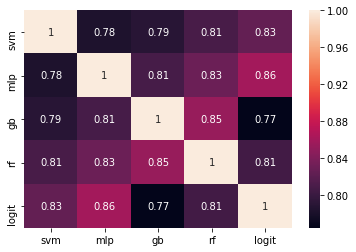

In [42]:
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [43]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('rf', rf_clf), ('logit', logit_clf),
('gb', gb_clf), ('lgb',lgb_clf),('mlp',mlp_clf)], voting='soft')

votingC = votingC.fit(tr, label)

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [44]:
test_Survived = pd.Series(votingC.predict(te), name="Survived")

results = pd.concat([test['PassengerId'],test_Survived],axis=1)
results["Survived"] = results["Survived"].astype(np.int8)

results.to_csv("ensemble_python_voting3.csv",index=False)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
test_Survived = pd.Series(mlp_pred, name="Survived")

results = pd.concat([test['PassengerId'],test_Survived],axis=1)
results["Survived"] = results["Survived"].astype(np.int8)

results.to_csv("mlp2.csv",index=False)

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.Cabin = le.fit_transform(df.Cabin)

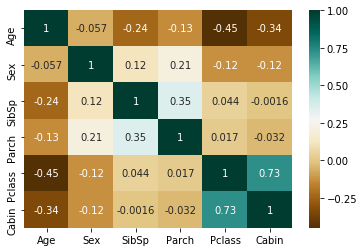

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
g = sns.heatmap(df[["Age","Sex","SibSp","Parch","Pclass",'Cabin']].corr(),cmap="BrBG",annot=True)

In [14]:
df.Pclass = df.Pclass.astype(int)